# Coursework - Advanced Data Science - CMM536 

## - Surya L Ramesh (0206793)


### <font color='blue'>Introduction:</font> 

The mask-mandate for protection against the COVID-19 pandemic has affected the field of facial recognition, where a need has risen to recognise faces with masks on. Efficient recognition systems are expected to check that faces are masked in regulated areas. This coursework is focuses on the facial recognition used to check if the detected face is correctly masked or unmasked, which can help with the enforcing the mask mandate. 
As an added level of complexity, this coursework looks at detecting incorrectly placed masks as well. Many people do not wear the masks correctly simply due to bad practice, lack of understanding or due to vulnerabilities of individuals. The class labels for this classification task have been chosen as:

- Unmasked
- CorrectlyMasked
- IncorrectlyMasked



###   <font color='blue'>Task 1: Data Compilation </font>  


Keeping the three class labels in mind, a search was carried out for suitable images.

The Unmasked dataset was created from the [Flickr-Faces-HQ(FFHQ)][1] which contains high quality images of human faces and was created as a benchmark for generative adversarial networks (GAN).This dataset contains a good variation in terms of age, ethnicity and also variation of accessories like hats and glasses which the model can learn from.
The Masked and Incorrectly masked data was compiled from [MaskedFace-Net][2] contains images of human faces with a correctly or incorrectly worn mask (133,783 images) based on the FFHQ dataset mentioned above. Masks have been artificially applied to the FFHQ dataset according to the categories. 

Incorrectly Masked contains 3 sub-categories:

- Uncovered nose *chosen as IncorrectlyMasked
- Uncovered chin
- Uncovered nose and mouth.


For the purposes of this coursework the granularity of the of the dataset is not exploited to the fullest extent, as the Incorrectly Masked currently contains only 'Uncovered nose' images, as it is the mostly commonly found in real life.This is because this project is considered as a first step in experimentation and not a final solution. 

The incorrectly labelled and unclear images were removed. The masked and incorrectly masked images of children under 3 were removed as well, as it is an impractical scenario.Then 2000 of each of the three categories was chosen for a range of ethnicity,ages and accessories.

**Final Selection**: The data was imbalanced to simulate real conditions, through code. The sizes now are: 

- Unmasked: 1000 
- CorrectlyMasked: 800 
- IncorrectlyMasked: 100


[1]:https://github.com/NVlabs/ffhq-dataset "FFHQ-Dataset"
[2]:https://github.com/cabani/MaskedFace-Net "MaskedFace-Net"


The Layout of the experiments and the submitted files are shown below.

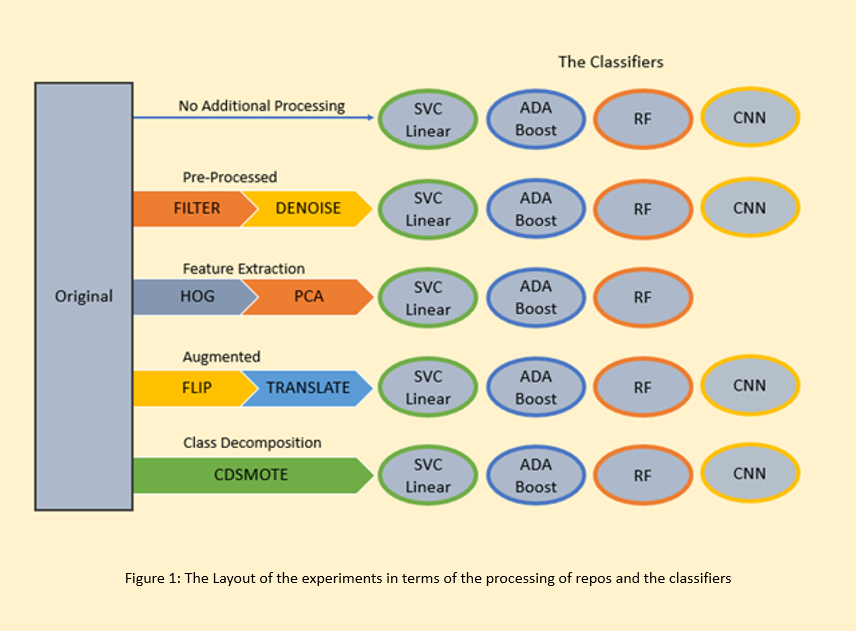

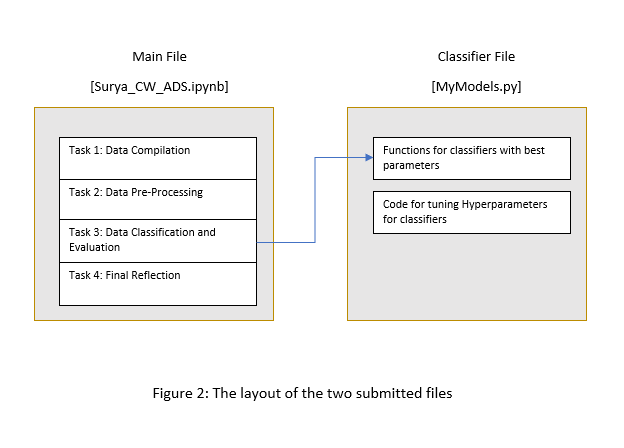

In [1]:
# Libraries 

import os
import matplotlib.pyplot as plt 
import matplotlib
import numpy as np
import cv2
import random
import pandas
import csv

import tensorflow as tf
from pandas import DataFrame
from sklearn.model_selection import train_test_split

from skimage.filters import try_all_threshold
from skimage.restoration import denoise_bilateral
from skimage.filters import sobel
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import sys

import clustData
import computeKVs
import numpy as np
import csv
import math
import pandas as pd
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
  
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
from sklearn import metrics

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import StratifiedShuffleSplit
from termcolor import colored

import MyModels            


In [2]:
# common functions

In [3]:
# function to show images 

def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [4]:
# function to display multiple images with titles

from PIL.Image import Image as PilImage
import textwrap

def display_images(imageset_array, titles, width=20, height=8, max_images=11, 
    label_wrap_length=50, label_font_size=8):
    columns=len(imageset_array);
    first_imageset = imageset_array[0] 
    if not first_imageset:
        print("No images to display.")
        return 

    if len(first_imageset) > max_images:
        print(f"Showing {max_images} images of {len(first_imageset)}:")
        first_imageset=first_imageset[0:max_images]
    height = max(height, int(len(first_imageset)) * height)
    
    plt.figure(figsize=(width, height))
    for i, image in enumerate(first_imageset):
        for j, imageset in enumerate(imageset_array):      
            plt.subplot(max_images, columns,  i*columns+j+1)
            plt.imshow(imageset[i],cmap='gray')        
            title=titles[j]
            title=textwrap.wrap(title, label_wrap_length)
            plt.title(title, fontsize=label_font_size);   
           
        

In [5]:
# function to save flattened data as .csv

def save_CSV(filename,flattened_data,target):
    print('\nSaving datasets as .csv files...')   

    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        filewriter = csv.writer(csvfile, delimiter=',')
        for i, pix in enumerate(flattened_data):
            row = np.concatenate((pix,[target[i]]))
            filewriter.writerow(row)

    print('\nData saved into .csv files!')  

## <font color='blue'>Task 2: Data Pre-processing</font>

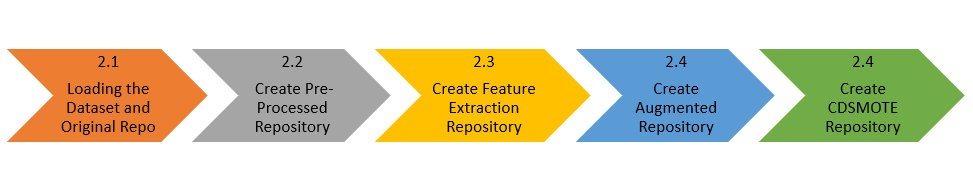



### <font color='black'> Task 2.1: Loading the Dataset and Original Repo  </font> 

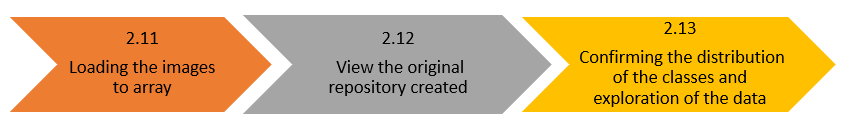

In [6]:
# 2.11 loading the data 

resize_width = 200     # chosen dimensions for the image
resize_height= 200     # chosen dimensions for the image

path = 'Data'
images = []            # List to append the images as 2D numpy arrays
target = []            # List for storing the 'class'
originalrepo = []      # Create a repo for flattened pixels
images_by_class = {}   # Dictionary of images grouped by class

num_um = 1000          # set number of images  in unmasked
num_cm = 800           # set number of images  in correctly masked
num_in = 100           # set number of images  in incorrectly masked
        

images_limit = { 'UnMasked':num_um,
                 'CorrectlyMasked':num_cm , 
                 'IncorrectlyMasked':num_in, 
               }

dirList = os.listdir(path)
for dir in dirList:
  sub_path = os.path.join(path, dir)  
  for dirpath, dirnames, filenames in os.walk(sub_path):
    n= images_limit.get(dir) 
    #print(n)
    for filename in [f for f in filenames ][:n]:
        #print (os.path.join(sub_path,filename))
        img = cv2.imread(os.path.join(sub_path,filename), cv2.IMREAD_GRAYSCALE) # images read as grayscale for this project
        img = cv2.resize(img, (resize_width, resize_height)) 
        images.append(img)
                    
        # Append the flattened image to the pixel repo        
        originalrepo.append(img.flatten())
        
        # Append the folder where the image is to the target list
        className = dir
        target.append(className) 

        #Group images by className 
        if className in images_by_class:
            images_by_class[className].append(img.flatten())
        else:
            images_by_class[className] = [img.flatten()]

#save_CSV('Original.csv',originalrepo,target) # commented out to save time 



In [7]:
# 2.12 View the repository created

# Convert the repo list into numpy array

originalrepo_np = np.array(originalrepo) 
#print(originalrepo)         # commented out for clarity 
#print(target)               # commented out for clarity 


# Convert the repo list into pandas dataframe

originalrepowtarget = DataFrame(originalrepo) 
originalrepowtarget['class']=DataFrame(target)
originalrepowtarget.head(5)   # display first 5 lines 


,0,1,2,3,4,5,6,7,8,9,...,39991,39992,39993,39994,39995,39996,39997,39998,39999,class
0,2,2,2,2,3,3,6,6,6,8,...,149,146,146,147,146,144,134,143,153,CorrectlyMasked
1,175,176,176,176,177,177,177,174,173,171,...,63,66,66,69,69,69,69,64,59,CorrectlyMasked
2,253,251,253,251,252,251,252,240,250,253,...,144,140,147,153,156,182,199,189,176,CorrectlyMasked
3,17,10,11,12,12,13,10,10,12,11,...,150,150,151,152,151,153,155,155,156,CorrectlyMasked
4,219,217,219,216,216,216,214,213,215,215,...,162,136,136,137,134,120,121,108,101,CorrectlyMasked


In [8]:
# confirm shape of original repo

originalrepo_np.shape


(1900, 40000)

In [9]:
# 2.13 Confirming the distribution of the classes and exploration of the data

# How to display the total categories - summary or count?

originalrepowtarget['class'].value_counts()

#shows an inbalanced  classes in our dataset

UnMasked             1000
CorrectlyMasked       800
IncorrectlyMasked     100
Name: class, dtype: int64

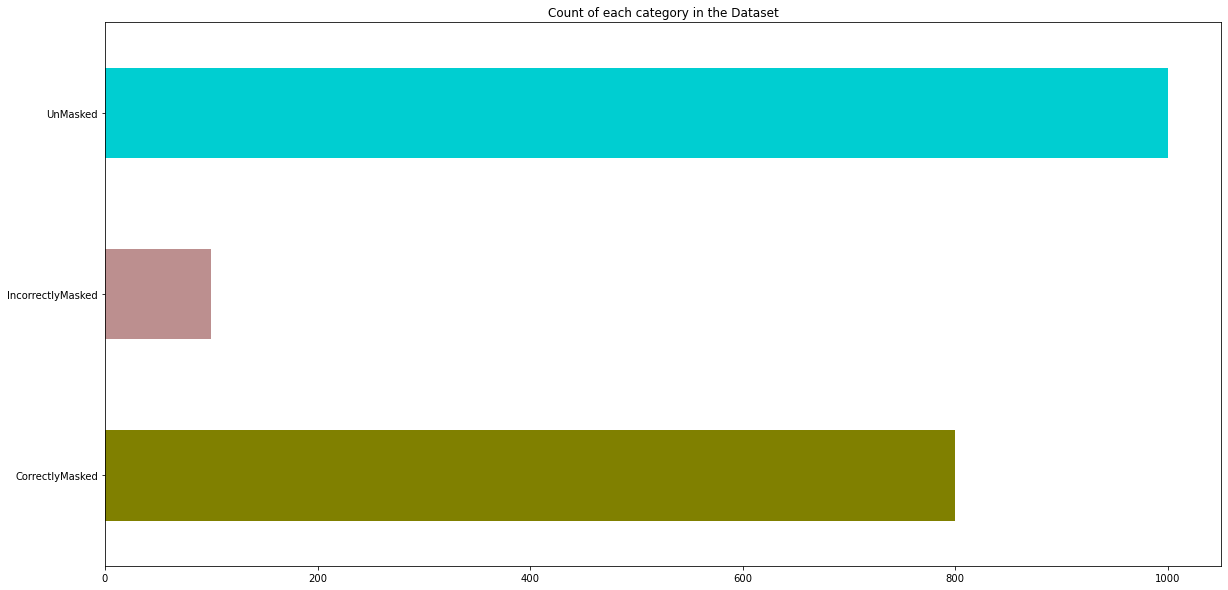

In [10]:
# view the count in each class

plt.figure(figsize =((20,10)))

originalrepowtarget['class'].value_counts().sort_index().plot.barh(title = "Count of each category in the Dataset",color=['olive','rosybrown', 'darkturquoise'])


In [11]:
# show sample image from the flattened original repo here 

originalrepo[10]




array([ 85,  82,  77, ..., 102, 100, 100], dtype=uint8)

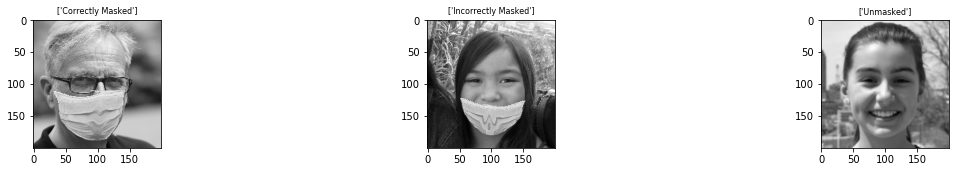

In [12]:
# choose one image from each class for display 

index1 = len(images_by_class['CorrectlyMasked'])-2
index2 = index1 + len(images_by_class['IncorrectlyMasked'])-2
index3 = index2 + len(images_by_class['UnMasked'])-2

sample = [[images[index1]],[images[index2]],[images[index3]]]

# call display function to view the images 

display_images(sample,["Correctly Masked ","Incorrectly Masked ","Unmasked"],max_images=3)


                                     ******* END OF DATA LOADING SECTION *******


## <font color='blue'> Task 2.2: Pre-processed Repository  </font> 

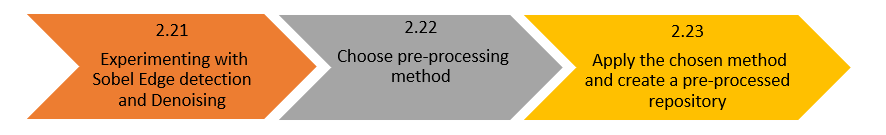

In [14]:
# function for just sobel

def filter_sobel(image):
    
    sobel_image = sobel(image)          
    return sobel_image



In [15]:
# function to apply denoising then filter

def denoising_filter(image):
    
    denoised_original = denoise_bilateral(image,multichannel=False)     
    sobel_original = sobel(image)       
    denoised_sobel = sobel(denoised_original)        
    return denoised_sobel



In [16]:
# function to apply filtering then denoise

def filter_denoising(image):        
    
    sobel_original = sobel(image)        # apply sobel edge filtering      
    denoised_orginal = denoise_bilateral(image,multichannel=False)     
    sobel_denoised = denoise_bilateral(sobel_original,multichannel=False)    
    return sobel_denoised

In [17]:
#function for preprocessing - filter + denoising and add to repo

def Preprocess_repo(image):
    
    sobel_original = sobel(image)                   # apply sobel edge filtering  
    sobel_denoised = denoise_bilateral(sobel_original,multichannel=False)    
    PP_repo.append(sobel_denoised)                  #apply denoising
    PP_repoflatten.append(sobel_denoised.flatten()) # flatten the repo
    


###  2.21 Experimenting with Sobel Edge detection and Denoising 

To compensate for loss of resolution due to cropping, sobel edge detection is used to extract the structures in the images. The aim is to focus on the features needed rather than the background or other distractions.Combining denoising which suppresses noise with sobel is done to check if the unnecessary details can be smoothed out to help with the classification.


In [18]:
# Apply sobel to limited number of images 
n = 0
sobel_image = []

for  x in images:
    
    if n > 3:break    # only first two images chosen  for display 
    sobel_image.append(filter_sobel(x))      
    n = n+1


In [19]:
#  Apply denoising + sobel to limited number of images

n = 0
denoised_filtered = []

for  x in images:
    
    if n > 3:break    # only first two images chosen  for display 
    denoised_filtered.append(denoising_filter(x))      
    n = n+1
    
    


In [20]:
#  Apply edge detection sobel + denoising (reverse order) to limited number of images

n = 0
filtered_denoised = []
for  x in images:
    
    if n > 3:break    # only first two images chosen  for display         
    filtered_denoised.append(filter_denoising(x))    
    n = n+1


### 2.22 Choose Pre-processing method

Comparing the outputs of both the pre-processing steps above - it was decided to go with Filter +Denoised as it provided clarity while reducing noise. 

Showing 3 images of 4:


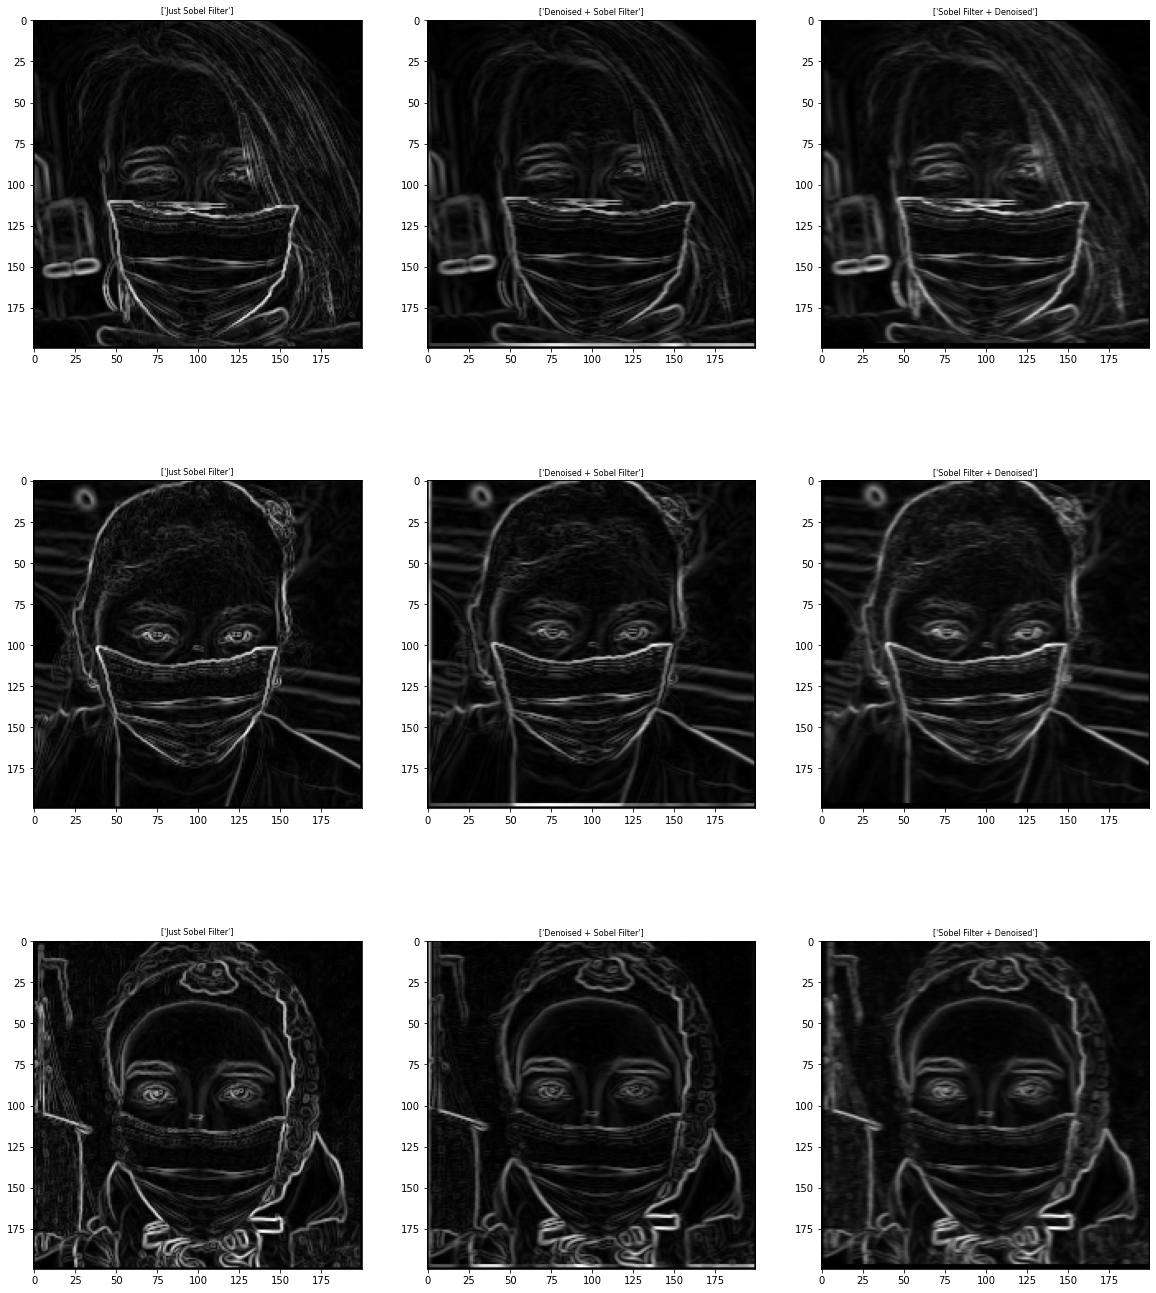

In [21]:
# display limited number of images from the above experminent 

display_images([sobel_image,denoised_filtered,filtered_denoised],["Just Sobel Filter","Denoised + Sobel Filter","Sobel Filter + Denoised"],max_images=3)





### 2.23 Apply the chosen method and create a pre-processed repository 

In [22]:
# apply pre-processing and save the flattened file as csv 

PP_repo =[]
PP_repoflatten=[]


for  x in images:  
          
        Preprocess_repo(x)                             # call function to apply chosen preprocessing 
      
    
print('Chosen Preprocessing is completed!')
print('Preprocessed file is flattened!')

save_CSV('Preprocessed.csv',PP_repoflatten,target)      # call function to save as csv,can be commented out to save time

Chosen Preprocessing is completed!
Preprocessed file is flattened!

Saving datasets as .csv files...

Data saved into .csv files!


                             ******* END OF  PRE-PROCESSING  SECTION *******

## <font color='blue'> Task 2.3: Feature Extraction Repository  </font> 

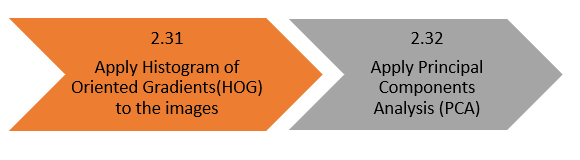

In feature extraction, a simplified representation of the image is created that contains only the most important information.Histograms of Oriented Gradients(HOG) is a type of feature extraction which is widely used in object  and human detection as seen in [Histograms of Oriented Gradients for Human Detection][5]

To reduce the computational burden, HOG has been used to extract the features and then Principal Component Analysis (PCA) is applied to reduce the dimensions of the extracted features. 
This paper,[HOG feature descriptor based PCA with SVM for efficient & accurate classification of objects in images][4] shows that the HOG with PCA along with SVM produced the best results. 

Hence,HOG + PCA is going to be applied to all the images. 

[4]:https://ieeexplore.ieee.org/document/8971585 "HOG+PCA"
[5]:http://lear.inrialpes.fr/people/triggs/pubs/Dalal-cvpr05.pdf "HOG-ref "

In [23]:
# libraries for this section

from skimage.feature import hog
from skimage import exposure


In [24]:
# HOG function 

def FE_Hog_flattened(x):
    
    img_features = x.flatten()
    fd, hog_image = hog(x, orientations=20, pixels_per_cell=(15, 15),
                    cells_per_block=(1, 1), visualize=True, multichannel=False)    
    
    flat_features = np.hstack([img_features,fd])
    return flat_features,hog_image


### 2.31 Apply Histogram of Oriented Gradients (HOG) to Data

In [25]:
# apply the chosen Feature Extraction (HOG) to the to flattened images

HOG_repo = []
HOG_repoflatten =[]
HOG_features=[]

for  x in images:       
  
    image_features,hog_image = FE_Hog_flattened(x)    # call HOG function
    HOG_features.append(image_features)               # append features
    HOG_repo.append(hog_image)                        # append to repo
    

# convert list of arrays into a matrix

feature_matrix = np.array(HOG_features)               # create a matrix of features


    

Showing 2 images of 1900:


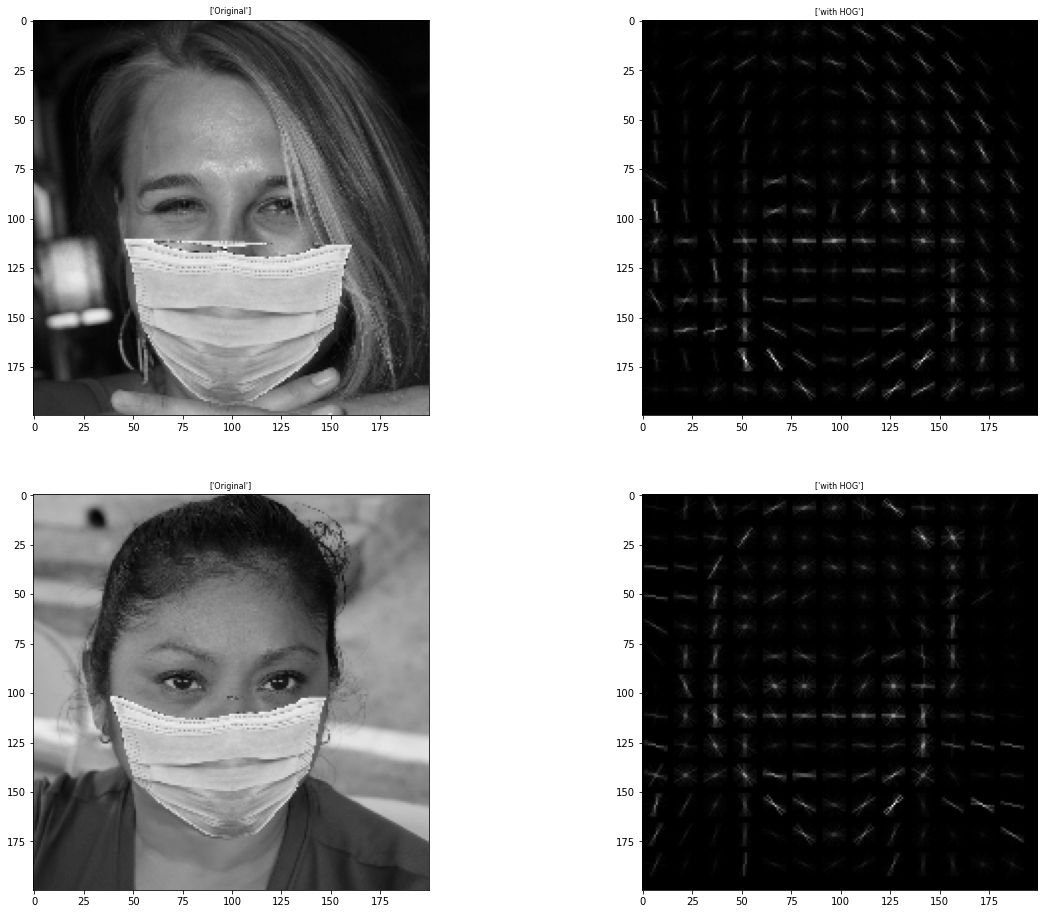

In [26]:
# display images to verify 

display_images([images,HOG_repo],["Original","with HOG"], max_images=2)

### 3.32 Apply Principal Component Analysis (PCA)

In [27]:
# Scale feature matrix + PCA

# get shape of feature matrix

print('Feature matrix shape is: ', feature_matrix.shape)


ss = StandardScaler()                               # define standard scaler

HOG_stand = ss.fit_transform(feature_matrix)        # run standard scaler on our feature matrix

pca = PCA(n_components=40)

HOG_pca = pca.fit_transform(HOG_stand)              # run PCA on the standardized matrix

print('PCA matrix shape is: ', HOG_pca.shape)       # look at new shape



Feature matrix shape is:  (1900, 43380)
PCA matrix shape is:  (1900, 40)


                             ******* END OF FEATURE EXTRACTION SECTION *******

## <font color='blue'> Task 2.4: Augmented Repository  </font> 
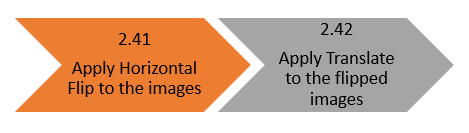

Of the Data Augmentation techniques possible, geometric transformations - Horizontal reflection (HR)  and translation(TR), have been chosen as they have been demonstrated to show some improvement in accuracy for emotion detection in this paper:[Evaluation of Data Augmentation Techniques for Facial Expression Recognition Systems ][6].

[6]: https://www.mdpi.com/2079-9292/9/11/1892 "Evaluation-of-Data-Augmentation-Techniques-for-Facial-Expression-Recognition-Systems"

In [28]:
# function for augmentation

# border value chosen as 126 for a gray colour rather teh automatically chosen black '0', white '255'

def flip_translate(image, shift_x, shift_y):
    flipped = cv2.flip(image,1)   #5  '1' is for horizontal flip 
    # shifted along x and y axis 
    matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    ft_return = cv2.warpAffine(flipped , matrix , (flipped.shape[1], flipped.shape[0]),borderValue = 126)
    return ft_return

In [29]:
# 2.41, 2.42 - sections for horizontal flip and translate combined into one 


Augmented_repo = []
Augmented_repoflatten =[]
Augmented_target =[]

    
for i in range(len(images)):
    r = images[i].copy()   
    Augmented_repo.append(r) 
    Augmented_repoflatten.append(r.flatten())
    Augmented_target.append(target[i])
    Aug= flip_translate(r,25,10)
    Augmented_repo.append(Aug) 
    Augmented_repoflatten.append(Aug.flatten())
    Augmented_target.append(target[i])

 
print('\nAugmentation is applied!\n')

print('\nSample augmented repo:\n')

Augmented_repo[0]




Augmentation is applied!


Sample augmented repo:



array([[  2,   2,   2, ...,   4,   4,   4],
       [  2,   2,   2, ...,   5,   6,   4],
       [  2,   2,   2, ...,   3,   4,   4],
       ...,
       [ 47,  50,  48, ..., 139, 138, 126],
       [ 50,  49,  47, ..., 139, 141, 150],
       [ 46,  47,  49, ..., 134, 143, 153]], dtype=uint8)

In [30]:
print('\nSample augmented target:\n')

Augmented_target[0]


Sample augmented target:



'CorrectlyMasked'

Showing 2 images of 3800:


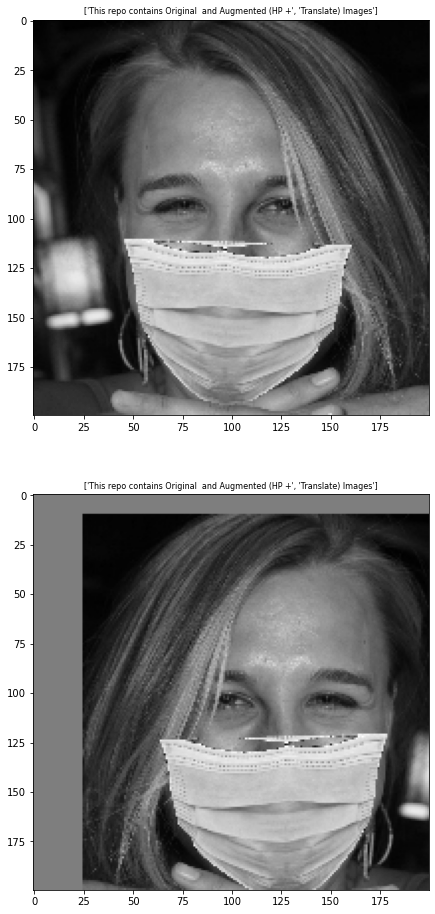

In [31]:
# display sample images 

display_images([Augmented_repo],["This repo contains Original  and Augmented (HP + Translate) Images"], max_images=2)



In [32]:
 #check size of repos now - the size should have doubled
    
print('\n The original repo length: ',len(originalrepo))
print('\n Augmented repo length: ',(len(Augmented_repo)))
print('\n The Augmented target length: ',(len(Augmented_target)))
    


 The original repo length:  1900

 Augmented repo length:  3800

 The Augmented target length:  3800


                                 ******* END OF AUGMENTED SECTION *******

 ## <font color='blue'> Task 2.5: Class Decompositon and Syntetic minority oversampling (CDSMOTE) repository  </font> 
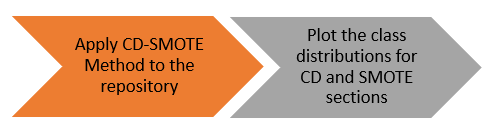

[CDSMOTE][5] is a new hybrid approach to correcting class imbalance. The proposed idea is a combination of under-sampling the majority class by class decomposition (CD) and oversampling the minority class by SMOTE. This reduces the dominance of majority class without information loss. 

The code for this section is an adaptation of https://github.com/carlosfmorenog/CDSMOTE-BINARY/blob/master/demo.ipynb


[5]:  https://link.springer.com/article/10.1007/s00521-020-05130-z "CDSMOTE:class-decomposition-and-synthetic-minority class-oversampling-technique-for-imbalanced-data-classification"




In [33]:
# Functions for CD-SMOTE

In [34]:
# function for plotting clusters (before CD)
def plot_precluster(target,maj_class,min_class):
    
    sns.set(style = "whitegrid")
#  Plot distribution 
    plt.figure(figsize =((15,10)))
    histo = [['Class','Number of Samples']]
    for i, label1 in enumerate(sorted(list(set(target)))):
        cont = 0
        for j, label2 in enumerate(target):
            if label1 == label2:
                cont+=1
        histo.append([label1,cont])
    histo.append(['Total Samples', len(target)])

    histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
    print(histo_panda)
    print('Total samples: '+str(len(target)))
    ## Find IR
    majority_samples = histo_panda.loc[histo_panda['Class'] == maj_class].reset_index()
    minority_samples = histo_panda.loc[histo_panda['Class'] == min_class].reset_index()

    IR = majority_samples['Number of Samples'][0]/minority_samples['Number of Samples'][0]
    print('Imbalance Ratio (IR): '+str(IR))

    print(majority_samples)
    ## Create a histogram using seaborn
    #sns.set_palette("prism")
    sns_plot = sns.barplot(x="Class", y="Number of Samples", data=histo_panda)


In [35]:
# function for class decompositon 

def decompose_class ( data,target,n_clust=4):
    sns.set(style = "whitegrid")    
    #n_clusters = 4
    plt.figure(figsize =((15,10)))
    ## Calculate k vector (for class decomposition)
    if k_type.lower() == 'fixed':
        k = computeKVs.majority(data, target, n_clust)
    elif k_type.lower() == 'ir':
        ## Calculate the IR between the majority and the minority
        n_clusters = math.ceil(IR) 
        k = computeKVs.majority(data, target,n_clust)
    else:
        print('Invalid option for k_type')
        sys.exit()
    print(k)
    ## 2. Cluster the data
    if classdecomp.lower()=='kmeans':
        target_cd = clustData.Kmeans(data, target, k)
    elif classdecomp.lower()=='fcmeans':
        target_cd = clustData.FCmeans(data, target, k)
    elif classdecomp.lower()=='fcmeansoptimised':
         target_cd = clustData.FCmeansOptimised(data, target, k, max_nclusters = 10)   
    elif classdecomp.lower()=='dbscan':        
         target_cd = clustData.DBSCAN(data, target, k, eps=0.5, min_samples=5)
    else:
        print('Invalid class decomposition algorithm.')
        sys.exit()
    return target_cd ##return 

In [36]:
# function for plotting clusters (after CD)

def plot_postcluster(target_cd):
    sns.set(style = "whitegrid")
    plt.figure(figsize =((20,10)))
    histo = [['Class','Number of Samples']]
    for i, label1 in enumerate(sorted(list(set(target_cd)))):
        cont = 0
        for j, label2 in enumerate(target_cd):
            if label1 == label2:
                cont+=1
        histo.append([label1,cont])
    histo.append(['Total Samples', len(target_cd)])

    ## Load as a panda
    histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
    print(histo_panda)
    print('Total samples: '+str(len(target_cd)))
    ## Create a histogram using seaborn
    #sns.set_palette("prism")
    sns_plot = sns.barplot(x="Class", y="Number of Samples",data=histo_panda)
  
    ## draw a line depicting the average
    indexesUnique = list(set(target_cd))
    indexesUnique.sort()
    cdclassdist_count = []
    cdclassdist_names = []
    for cdclass in indexesUnique:
         cdclassdist_count.append(target_cd.count(cdclass))
         cdclassdist_names.append(cdclass)
    average = sum(cdclassdist_count)/len(cdclassdist_count)
    print('Average number of samples per class:', average)
    plt.axhline(average, color='red')
    return cdclassdist_count,cdclassdist_names

In [37]:
def get_minority_majority(data_dictionary):
    longest = max(len(item) for item in data_dictionary.values())
    majority_class = [key for key, value in data_dictionary.items() if len(value) == longest]

    smallest = min(len(item) for item in data_dictionary.values())
    minority_class = [key for key, value in data_dictionary.items() if len(value) == smallest] 
    return majority_class[0], minority_class[0];

In [38]:
dataset = 'C15' # name of the dataset to use. C1-31 are binary datasets presented in Cleofas-Sanchez et al. 2016
classdecomp = 'Kmeans' # 'FCmeans', 'FCmeansOptimised' and 'DBSCAN' also available 
oversampler = 'SMOTE' #'ADASYN' also available
threshold = 10 # if samples in positive class are apart from average by more than this value, apply oversampling (Sec 3.2 paper)
k_type = 'fixed' # Indicates how to calculate k values for class decomposition
n_clusters = 4 # used in the "fixed" k_type option # passing in functio instead of here 
number_of_tests = 5  # How many times to repeat the SVM experiment comparing the original and new db


#NOTE: Class decomposition  only  finds clusters of data , similar to other data. 
#To evaluate the model the decomposed classes has been added together.

In [39]:
# apply CDSMOTE 

In [40]:
# applying class decomposition 

original_images_by_class = images_by_class.copy()
majority_class  = max(set(target), key=target.count)
minority_class  = min(set(target), key=target.count)

images_to_process = images_by_class[majority_class].copy()
images_to_process.extend(images_by_class[minority_class])

targets_to_process = [majority_class] * len(images_by_class[majority_class])
targets_to_process.extend([minority_class] * len(images_by_class[minority_class] ))


# This section is for debugging/ additional information- Commented out for clarity 

#print(len(images_by_class[majority_class]))
#print(len(images_by_class[minority_class]))
#print(len(images_by_class["CorrectlyMasked"]))
#print(len(targets_to_process))
#print(len(images_to_process))
#print(targets_to_process)

               Class  Number of Samples
0  IncorrectlyMasked                100
1           UnMasked               1000
Total samples: 1100
Imbalance Ratio (IR): 10.0
   index     Class  Number of Samples
0      1  UnMasked               1000


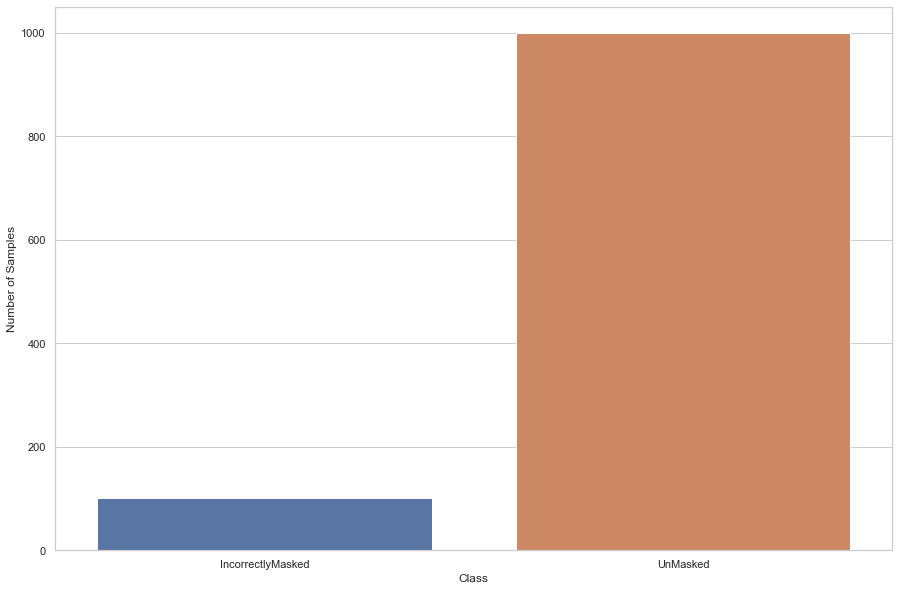

In [41]:
 plot_precluster(targets_to_process,majority_class,minority_class)

[1, 4]

Class decomposition by applying k-means...
No clustering performed for class IncorrectlyMasked.
Number of clusters for class UnMasked: 4
                  Class  Number of Samples
0  IncorrectlyMasked_c0                100
1           UnMasked_c0                257
2           UnMasked_c1                222
3           UnMasked_c2                264
4           UnMasked_c3                257
Total samples: 1100
Average number of samples per class: 220.0


<Figure size 1080x720 with 0 Axes>

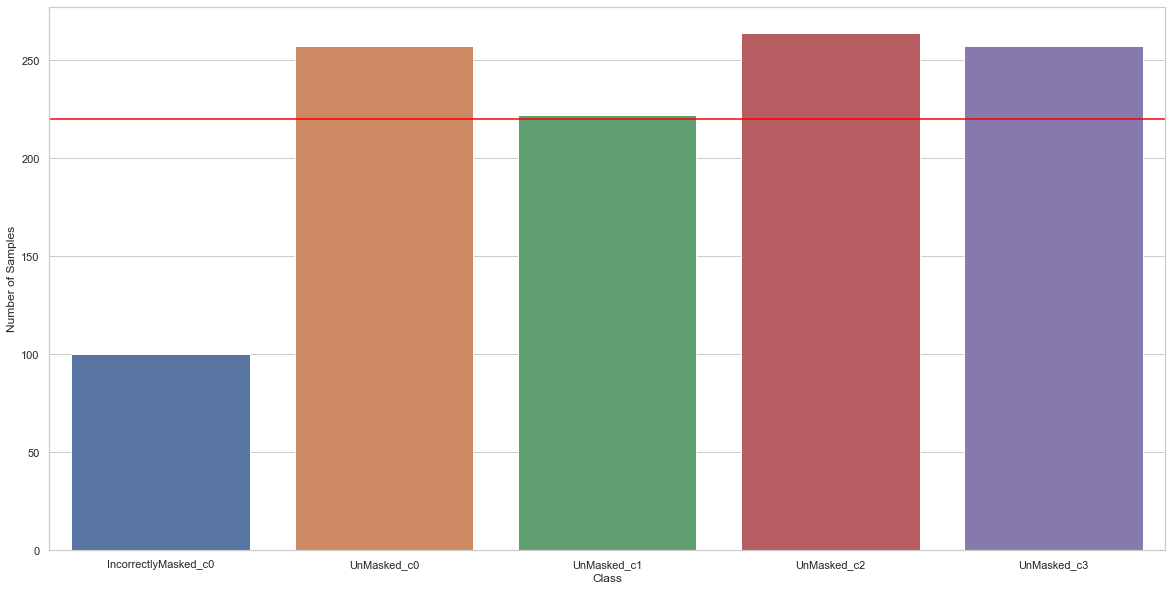

In [42]:
#decompose the classes
cdclassdist_count_1=[]
cdclassdist_names_1=[]
clustered_1 = decompose_class(images_to_process,targets_to_process,n_clusters)
cdclassdist_count_1,cdclassdist_names_1=plot_postcluster(clustered_1)

In [43]:
#remove the already decomposed class

new_images_by_class = original_images_by_class.copy()
new_images_by_class.pop(majority_class)

new_majority_class, minority_class = get_minority_majority(new_images_by_class)
new_images_to_process = new_images_by_class[new_majority_class].copy()
new_images_to_process.extend(new_images_by_class[minority_class])
new_targets_to_process = [new_majority_class] * len(new_images_by_class[new_majority_class])
new_targets_to_process.extend([minority_class] * len(new_images_by_class[minority_class] ))


               Class  Number of Samples
0    CorrectlyMasked                800
1  IncorrectlyMasked                100
Total samples: 900
Imbalance Ratio (IR): 8.0
   index            Class  Number of Samples
0      0  CorrectlyMasked                800


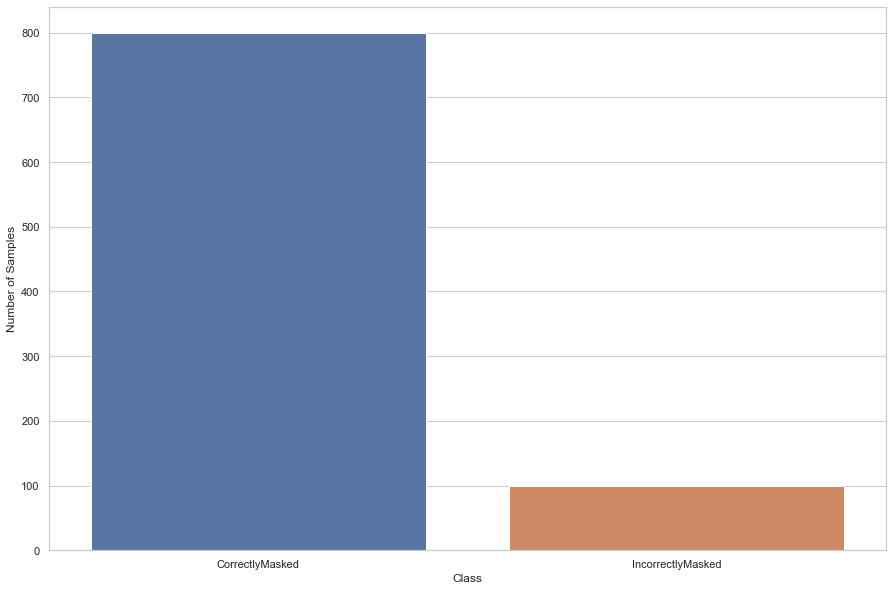

In [44]:
plot_precluster(new_targets_to_process,new_majority_class,minority_class)



[4, 1]

Class decomposition by applying k-means...
Number of clusters for class CorrectlyMasked: 4
No clustering performed for class IncorrectlyMasked.
                  Class  Number of Samples
0    CorrectlyMasked_c0                154
1    CorrectlyMasked_c1                181
2    CorrectlyMasked_c2                246
3    CorrectlyMasked_c3                219
4  IncorrectlyMasked_c0                100
Total samples: 900
Average number of samples per class: 180.0


<Figure size 1080x720 with 0 Axes>

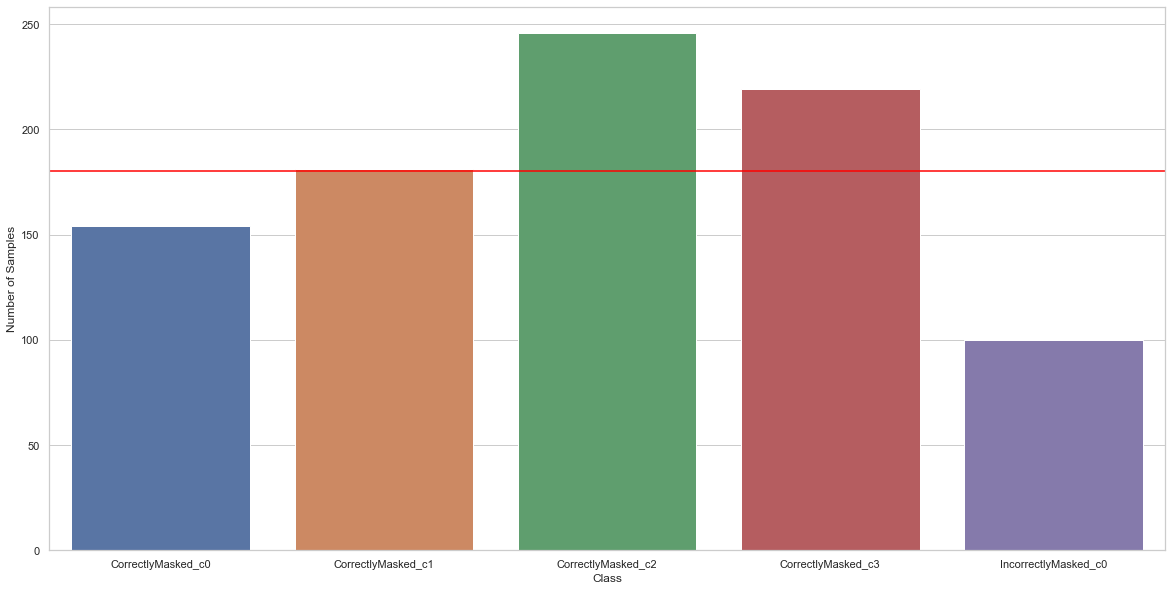

In [45]:
cdclassdist_count_2=[]
cdclassdist_names_2=[]
clustered_2 = decompose_class(new_images_to_process,new_targets_to_process,n_clusters)

cdclassdist_count_2,cdclassdist_names_2=plot_postcluster(clustered_2)


                  Class  Number of Samples
0    CorrectlyMasked_c0                154
1    CorrectlyMasked_c1                181
2    CorrectlyMasked_c2                246
3    CorrectlyMasked_c3                219
4  IncorrectlyMasked_c0                100
5           UnMasked_c0                257
6           UnMasked_c1                222
7           UnMasked_c2                264
8           UnMasked_c3                257
Total samples: 1900
Average number of samples per class: 211.11111111111111
Average number of samples per class in the combined: 211.11111111111111
[100, 257, 222, 264, 257, 154, 181, 246, 219]
['IncorrectlyMasked_c0', 'UnMasked_c0', 'UnMasked_c1', 'UnMasked_c2', 'UnMasked_c3', 'CorrectlyMasked_c0', 'CorrectlyMasked_c1', 'CorrectlyMasked_c2', 'CorrectlyMasked_c3']


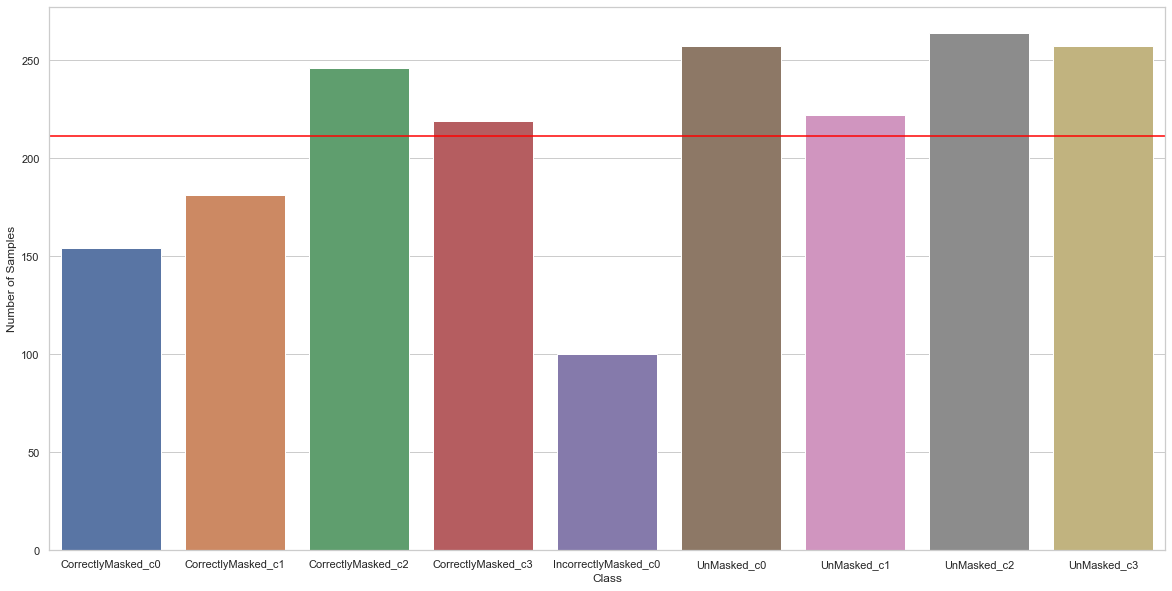

In [46]:
# Join the two clustured sets together and display as one

clust = []

clustered_2 = [x for x in clustered_2 if not x.startswith(minority_class)]
clust = clustered_1.copy()  
clust.extend(clustered_2)    
     
plot_postcluster(clust) 
cdclassdist_names = cdclassdist_names_1.copy()

for i in range(len(cdclassdist_names_2)):
    if cdclassdist_names_2[i].startswith(minority_class):
        del cdclassdist_names_2[i]
        del cdclassdist_count_2[i]

cdclassdist_names.extend(cdclassdist_names_2)
cdclassdist_count = cdclassdist_count_1.copy()
cdclassdist_count.extend(cdclassdist_count_2)


average = sum(cdclassdist_count)/len(cdclassdist_count)
print('Average number of samples per class in the combined:', average)

print(cdclassdist_count)
print(cdclassdist_names)


In [47]:
# apply SMOTE section 

Oversampling original minority class...
                  Class  Number of Samples
0    CorrectlyMasked_c0                154
1    CorrectlyMasked_c1                181
2    CorrectlyMasked_c2                246
3    CorrectlyMasked_c3                219
4  IncorrectlyMasked_c0                219
5           UnMasked_c0                257
6           UnMasked_c1                222
7           UnMasked_c2                264
8           UnMasked_c3                257
Total samples: 2019
New average number of samples per class: 48.666666666666664


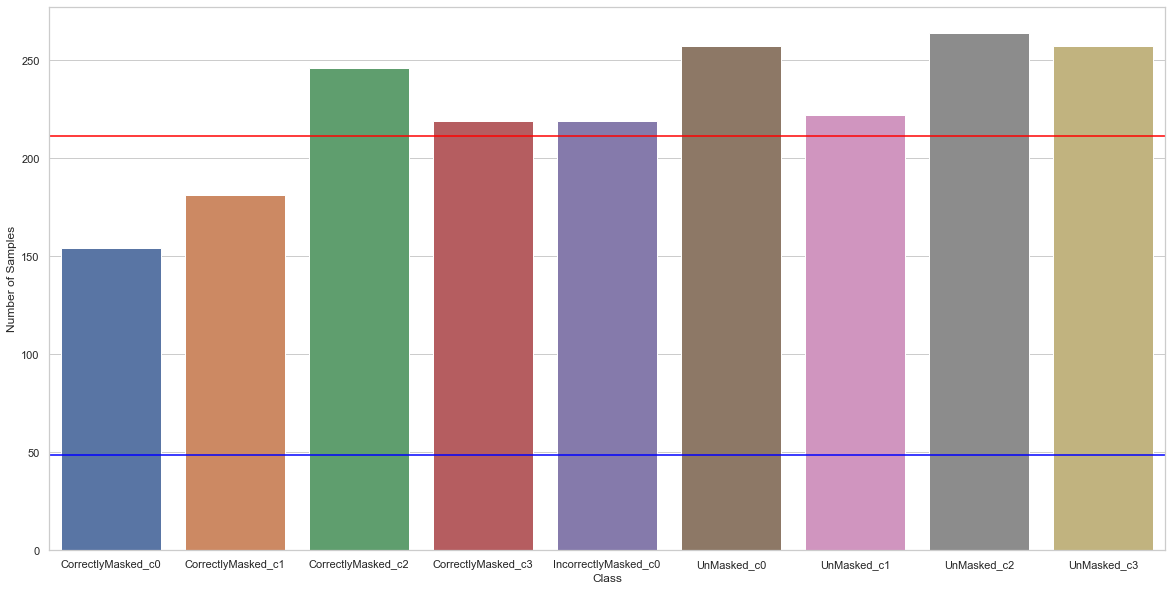

In [48]:
plt.figure(figsize =((20,10)))

## 1. See if the minority is far from the average (larger than the threshold)
flag = 0
for i,cdclassdist_name in enumerate(cdclassdist_names):
    if minority_class == cdclassdist_name.split('_')[0]:
        if abs(average-cdclassdist_count[i])>threshold and average>cdclassdist_count[i]:
            flag = 1
            newmin = cdclassdist_name
if flag ==1:            
    print('Oversampling original minority class...')
    ## 2. Calculate new majority class (closest to the average and larger than the minority) to use as reference for the oversampling
    c = np.inf
    newmaj = majority_class + '_c0' # gets picked by default if none other accomplishes
    for i,j in enumerate(cdclassdist_count):
        if abs(j-average)<c and j>average:
            c = abs(j-average)
            newmaj = cdclassdist_names[i]
    ## 3. Create the dataset that only contains the new majority and minority classes
    data_majmin = []
    target_majmin = []
    for m, label in enumerate(clust):
        if label == newmaj or label == newmin:
            data_majmin.append(originalrepo[m])
            target_majmin.append(label)
    if oversampler.lower() == 'smote':
        sm = SMOTE()
        data_over, target_over = sm.fit_resample(data_majmin, target_majmin) 
    elif oversampler.lower() == 'adasyn':
        ada = ADASYN()
        data_over, target_over = ada.fit_resample(data_majmin, target_majmin)
    else:
        print('Invalid oversampling algorithm.')
        sys.exit() 
    ## 4. combine this with the remaining classes
    data_cdsmote = data_over.copy()
    target_cdsmote = target_over.copy()
    for m, label in enumerate(clust):
        if label != newmin and label != newmaj:
            data_cdsmote.append(originalrepo[m])
            target_cdsmote.append(label)
            
            
            
    ## 5. Plot distribution after smote
    histo = [['Class','Number of Samples']]
    for i, label1 in enumerate(sorted(list(set(target_cdsmote)))):
        cont = 0
        for j, label2 in enumerate(target_cdsmote):
            if label1 == label2:
                cont+=1
        histo.append([label1,cont])
    histo.append(['Total Samples', len(target_cdsmote)])
    
    ## Load as a panda
    histo_panda = pd.DataFrame.from_records(histo[1:-1], columns=histo[0])
    print(histo_panda)
    print('Total samples: '+str(len(target_cdsmote)))
    ## Create a histogram using seaborn
    sns_plot = sns.barplot(x="Class", y="Number of Samples", data=histo_panda)
    ## draw a line depicting the average
    indexesUnique = list(set(target_cdsmote))
    indexesUnique.sort()
    newestclassdist_count = []
    for newestclass in indexesUnique:
         newestclassdist_count.append(target_over.count(newestclass))
    average_new = sum(newestclassdist_count)/len(newestclassdist_count)
    print('New average number of samples per class:', average_new)
    plt.axhline(average, color='red')
    plt.axhline(average_new, color='blue')
  
    plt.show()

else:
    data_cdsmote = originalrepo.copy()
    target_cdsmote = clust.copy()
    print('Original minority class is close to average. No oversampling needed.')
    
    

                                     ******* END OF CD-SMOTE SECTION *******

## <font color='blue'> Task 3: Data Classification and Evaluation </font> 



The chosen classfiers are: 

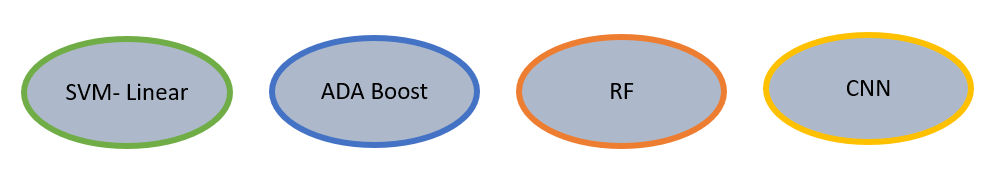

The training and testing framework is shown in Figure 3.

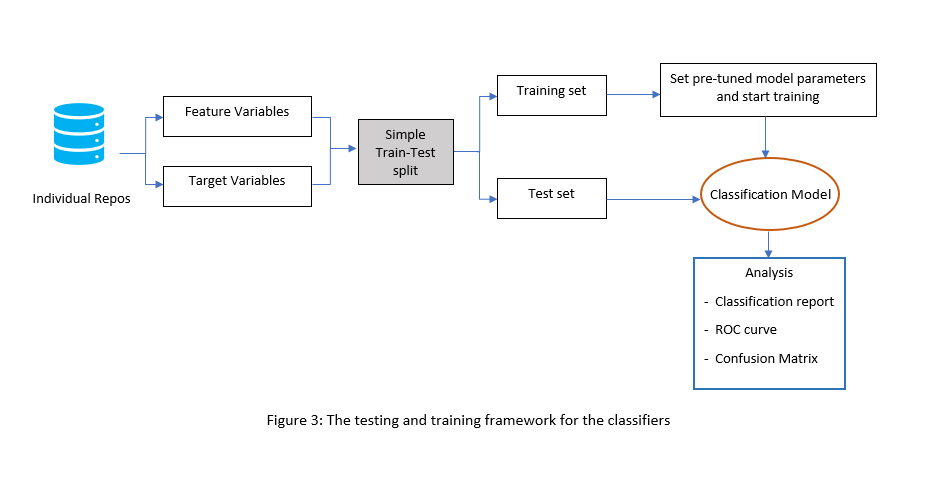


In [50]:
# NOTE-functions for the classifiers and hyperparameter tuning can be found in the Mymodels.py,attached to this coursework submission.

In [51]:
# libraries for this section

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ROCAUC

import itertools
import numpy as np
import matplotlib.pyplot as plt

In [52]:
# function for confusion matrix - used for CNN and CD-SMOTE Repo

    
def plot_confusion_matrix_custom(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes, rotation=45)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None) 
    plt.show()
      
    
    # code for this function is adapted from deeplizard.com

**Classifiers(ADAboost,RF,SVC) and all suitable repos**


 Processing   Original Repo

 The ADA boost Model is been initiated... 


 The ADA boost Model fitted and prediction is completed 


 The Random Forest Model is been initiated... 


 The Random Forest Model fitted and prediction is completed 


 The SVC Linear Model is been initiated... 


 The SVC Linear Model fitted and prediction is completed 



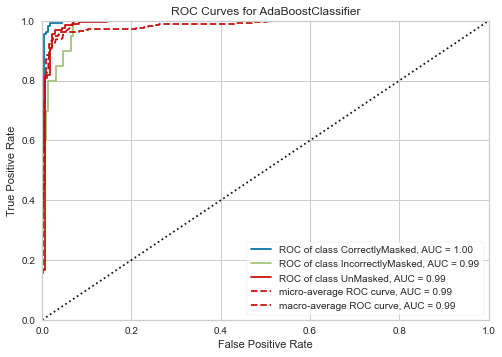

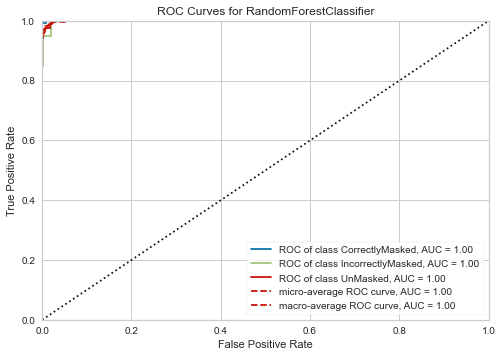

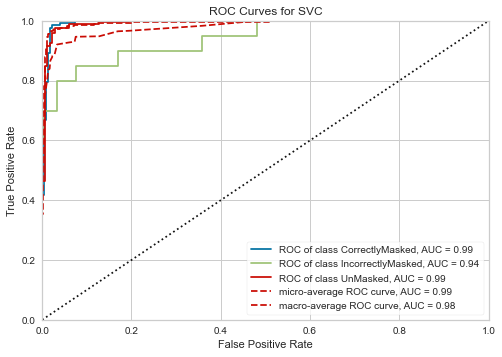


 Accuracy -Check for generalisation... -  for : Original Repo


 AdaBoostClassifier

The training scores were: [1.0]
The testing scores were: [0.95]

 RandomForestClassifier

The training scores were: [1.0]
The testing scores were: [0.98]

 SVC

The training scores were: [1.0]
The testing scores were: [0.96]

 The Classification Report for : Original Repo


 AdaBoostClassifier

                   precision    recall  f1-score   support

  CorrectlyMasked       0.99      0.96      0.97       160
IncorrectlyMasked       0.90      0.45      0.60        20
         UnMasked       0.92      0.99      0.95       200

         accuracy                           0.95       380
        macro avg       0.94      0.80      0.84       380
     weighted avg       0.95      0.95      0.94       380


 RandomForestClassifier

                   precision    recall  f1-score   support

  CorrectlyMasked       1.00      0.99      1.00       160
IncorrectlyMasked       1.00      0.75      0.86        2

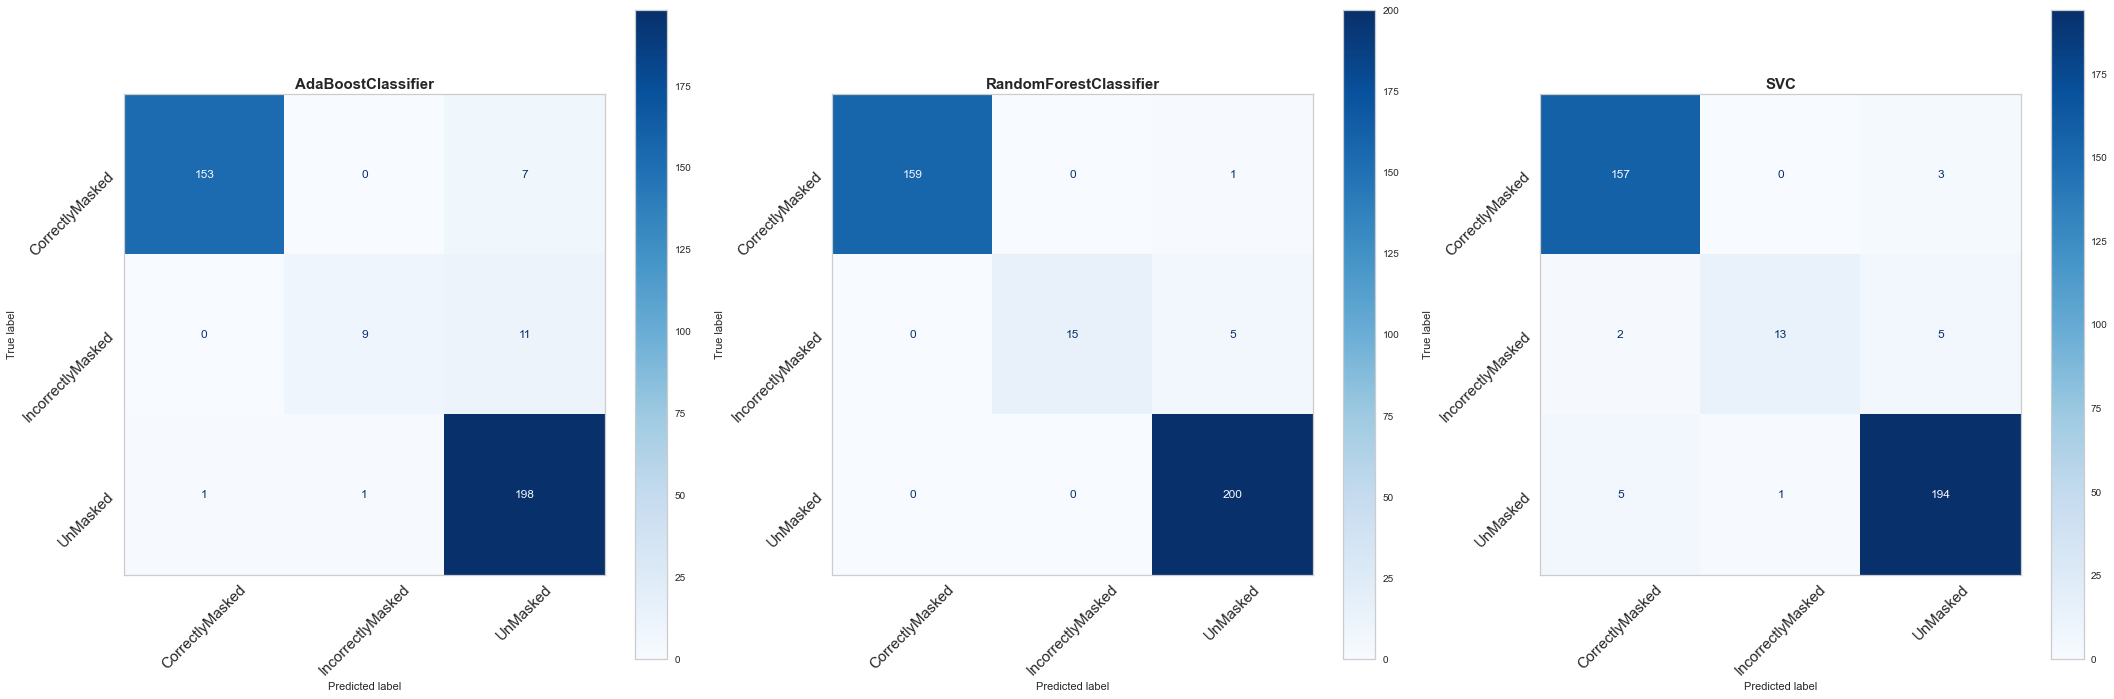


 Processing   Pre-processed Repo

 The ADA boost Model is been initiated... 


 The ADA boost Model fitted and prediction is completed 


 The Random Forest Model is been initiated... 


 The Random Forest Model fitted and prediction is completed 


 The SVC Linear Model is been initiated... 


 The SVC Linear Model fitted and prediction is completed 



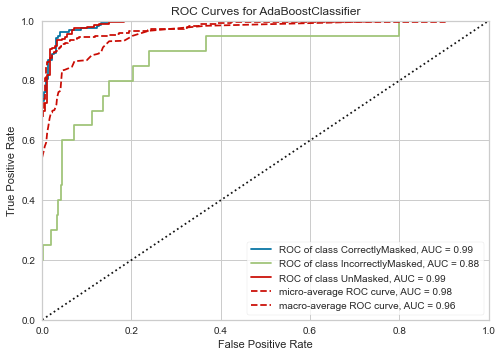

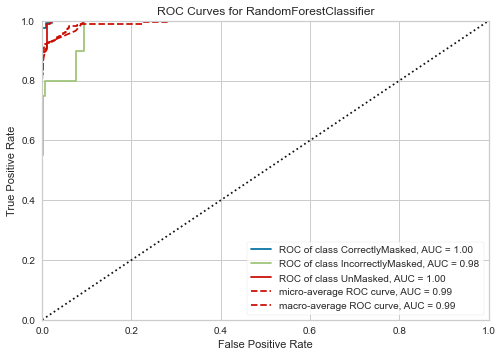

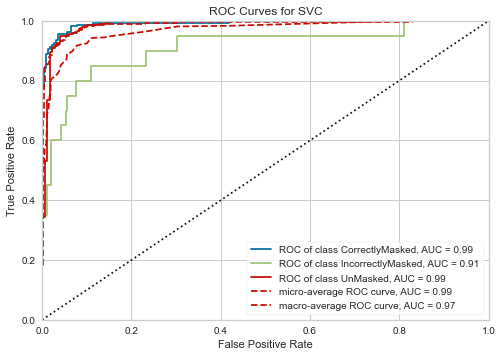


 Accuracy -Check for generalisation... -  for : Pre-processed Repo


 AdaBoostClassifier

The training scores were: [0.99]
The testing scores were: [0.92]

 RandomForestClassifier

The training scores were: [1.0]
The testing scores were: [0.93]

 SVC

The training scores were: [0.93]
The testing scores were: [0.91]

 The Classification Report for : Pre-processed Repo


 AdaBoostClassifier

                   precision    recall  f1-score   support

  CorrectlyMasked       0.97      0.93      0.95       160
IncorrectlyMasked       0.83      0.25      0.38        20
         UnMasked       0.89      0.98      0.93       200

         accuracy                           0.92       380
        macro avg       0.90      0.72      0.76       380
     weighted avg       0.92      0.92      0.91       380


 RandomForestClassifier

                   precision    recall  f1-score   support

  CorrectlyMasked       1.00      0.96      0.98       160
IncorrectlyMasked       1.00      0.10      0

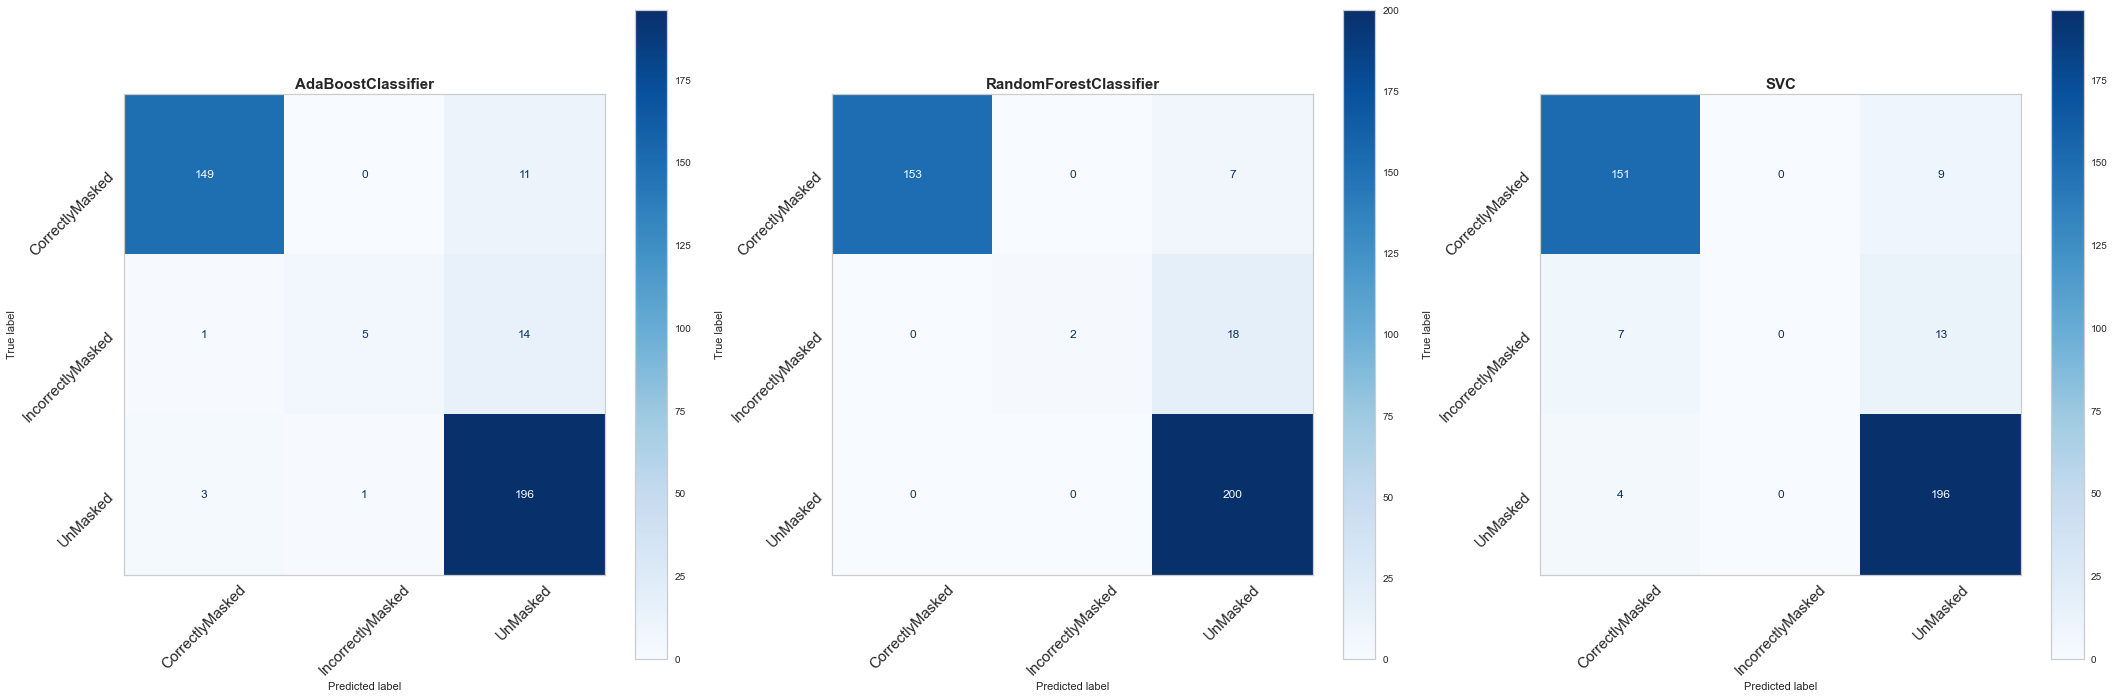


 Processing   HOG Repo

 The ADA boost Model is been initiated... 


 The ADA boost Model fitted and prediction is completed 


 The Random Forest Model is been initiated... 


 The Random Forest Model fitted and prediction is completed 


 The SVC Linear Model is been initiated... 


 The SVC Linear Model fitted and prediction is completed 



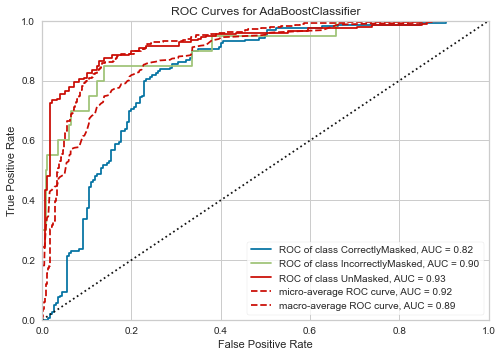

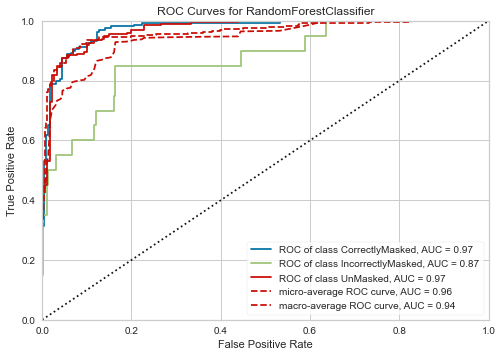

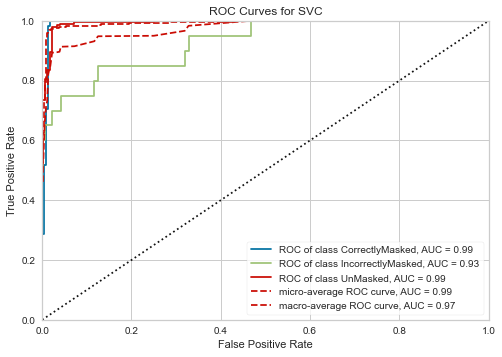


 Accuracy -Check for generalisation... -  for : HOG Repo


 AdaBoostClassifier

The training scores were: [0.93]
The testing scores were: [0.89]

 RandomForestClassifier

The training scores were: [0.99]
The testing scores were: [0.88]

 SVC

The training scores were: [0.97]
The testing scores were: [0.97]

 The Classification Report for : HOG Repo


 AdaBoostClassifier

                   precision    recall  f1-score   support

  CorrectlyMasked       0.85      0.94      0.90       160
IncorrectlyMasked       0.75      0.45      0.56        20
         UnMasked       0.93      0.89      0.91       200

         accuracy                           0.89       380
        macro avg       0.84      0.76      0.79       380
     weighted avg       0.89      0.89      0.88       380


 RandomForestClassifier

                   precision    recall  f1-score   support

  CorrectlyMasked       0.85      0.93      0.88       160
IncorrectlyMasked       1.00      0.10      0.18        20
     

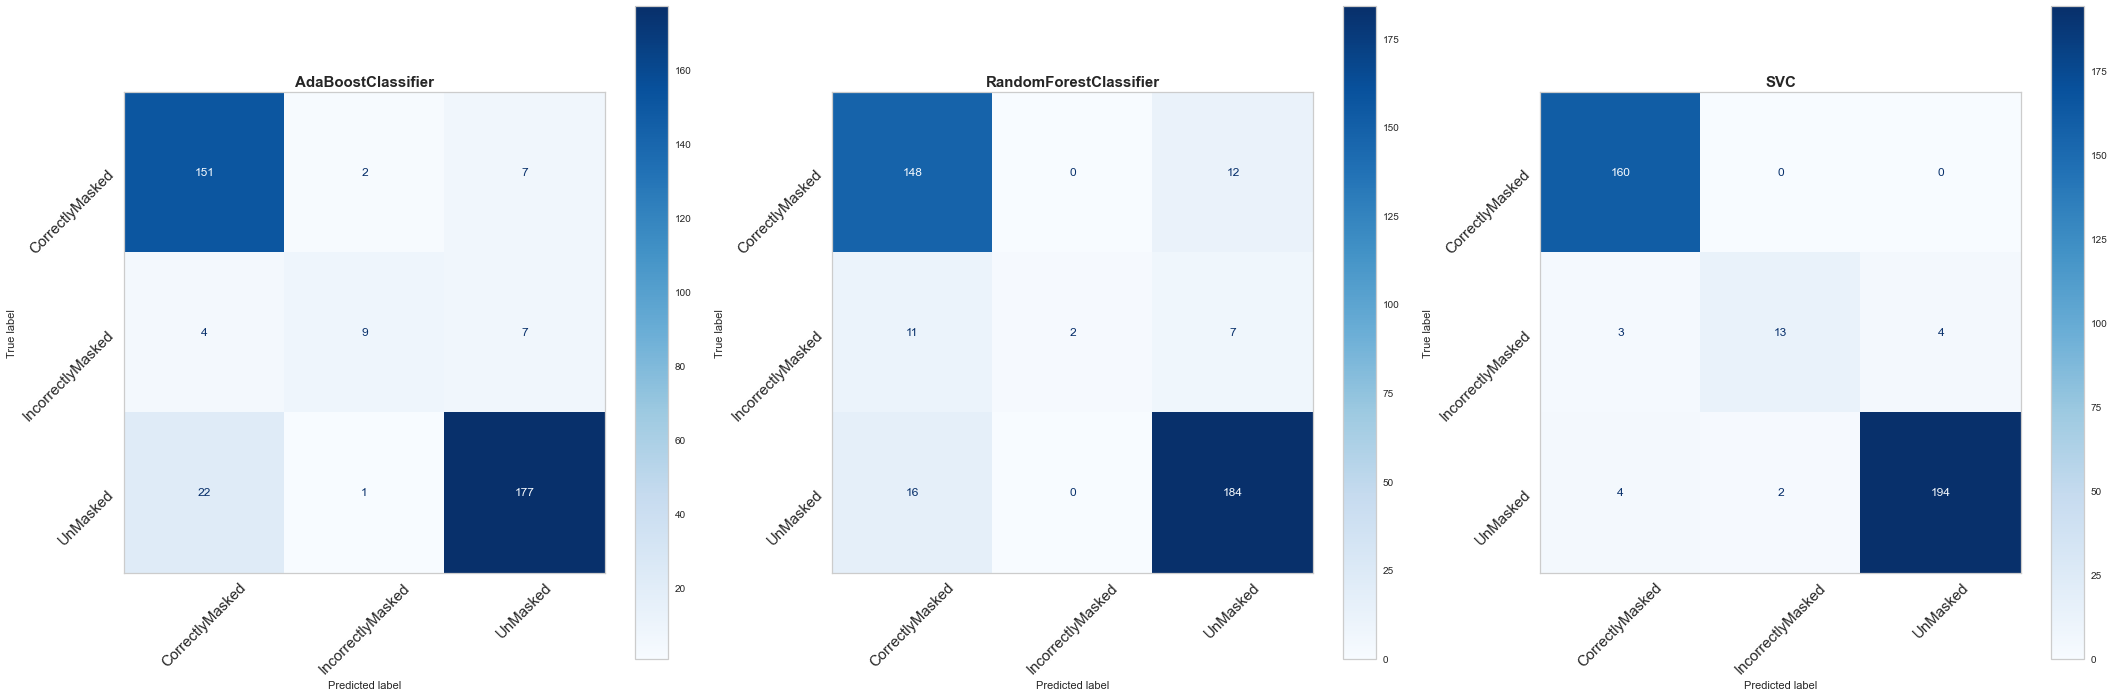


 Processing   Augmented Repo

 The ADA boost Model is been initiated... 


 The ADA boost Model fitted and prediction is completed 


 The Random Forest Model is been initiated... 


 The Random Forest Model fitted and prediction is completed 


 The SVC Linear Model is been initiated... 


 The SVC Linear Model fitted and prediction is completed 



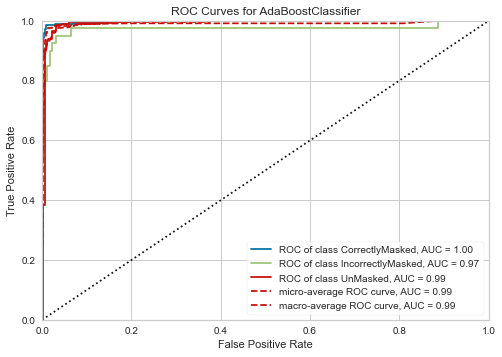

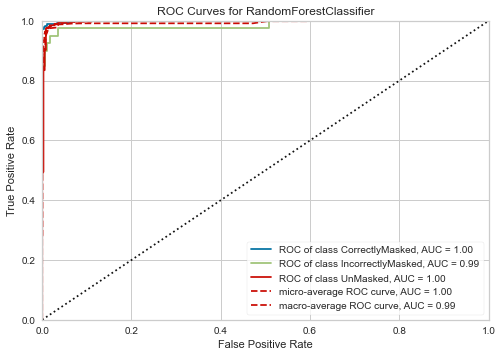

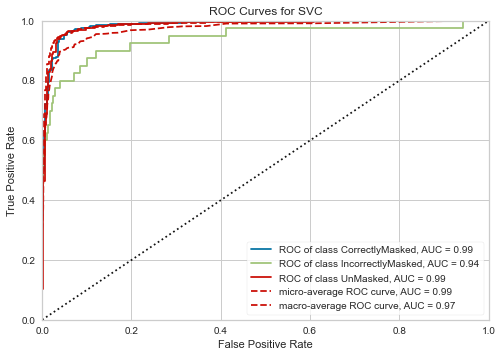


 Accuracy -Check for generalisation... -  for : Augmented Repo


 AdaBoostClassifier

The training scores were: [1.0]
The testing scores were: [0.98]

 RandomForestClassifier

The training scores were: [1.0]
The testing scores were: [0.98]

 SVC

The training scores were: [1.0]
The testing scores were: [0.93]

 The Classification Report for : Augmented Repo


 AdaBoostClassifier

                   precision    recall  f1-score   support

  CorrectlyMasked       0.99      0.99      0.99       320
IncorrectlyMasked       0.94      0.75      0.83        40
         UnMasked       0.98      1.00      0.99       400

         accuracy                           0.98       760
        macro avg       0.97      0.91      0.94       760
     weighted avg       0.98      0.98      0.98       760


 RandomForestClassifier

                   precision    recall  f1-score   support

  CorrectlyMasked       0.97      0.99      0.98       320
IncorrectlyMasked       0.94      0.75      0.83       

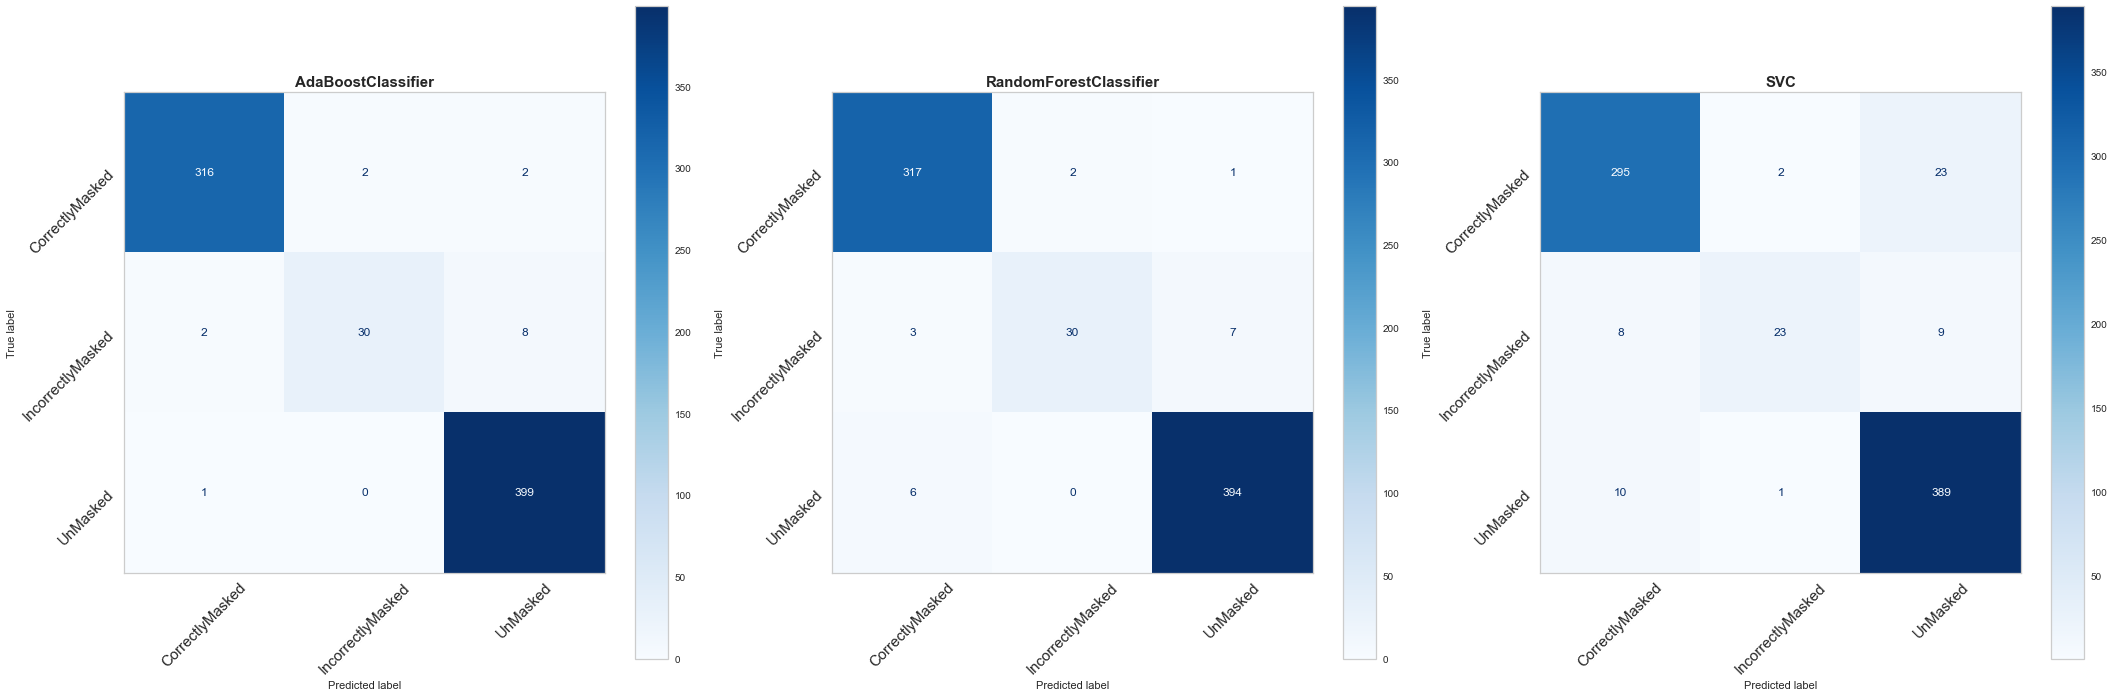


 Processing   CD-SMOTE Repo

 The ADA boost Model is been initiated... 


 The ADA boost Model fitted and prediction is completed 


 The Random Forest Model is been initiated... 


 The Random Forest Model fitted and prediction is completed 


 The SVC Linear Model is been initiated... 


 The SVC Linear Model fitted and prediction is completed 



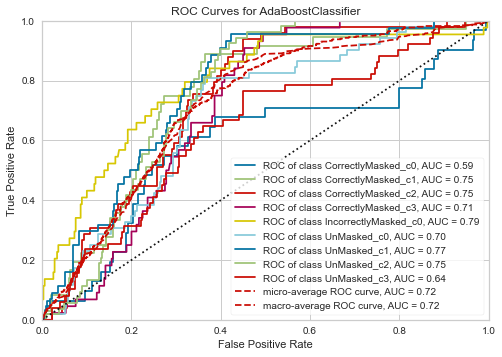

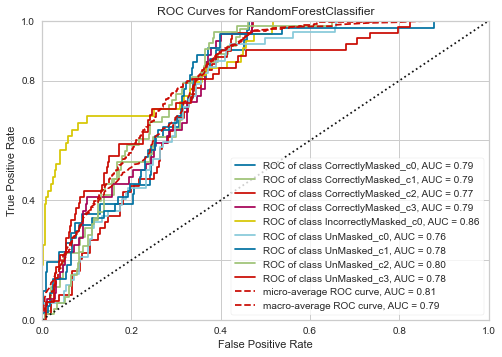

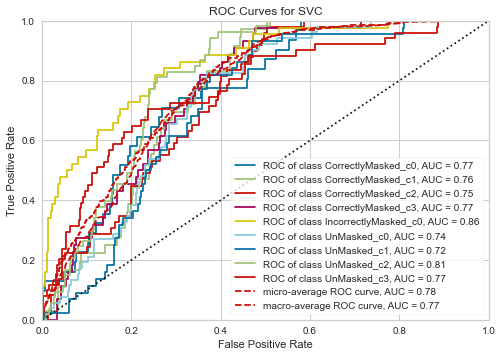


 Accuracy -Check for generalisation... -  for : CD-SMOTE Repo


 AdaBoostClassifier

The training scores were: [0.32]
The testing scores were: [0.23]

 RandomForestClassifier

The training scores were: [0.97]
The testing scores were: [0.29]

 SVC

The training scores were: [1.0]
The testing scores were: [0.29]

 The Classification Report for : CD-SMOTE Repo


 AdaBoostClassifier

                   precision    recall  f1-score   support

  CorrectlyMasked       0.80      0.78      0.79       160
IncorrectlyMasked       0.38      0.27      0.32        44
         UnMasked       0.86      0.92      0.89       200

         accuracy                           0.79       404
        macro avg       0.68      0.66      0.66       404
     weighted avg       0.78      0.79      0.79       404


 RandomForestClassifier

                   precision    recall  f1-score   support

  CorrectlyMasked       0.82      0.81      0.82       160
IncorrectlyMasked       0.51      0.61      0.56       

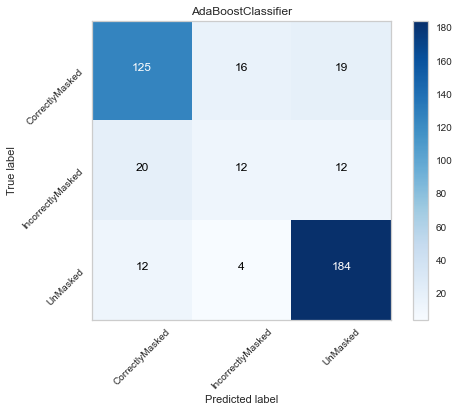

Confusion matrix, without normalization
[[130  25   5]
 [ 13  27   4]
 [ 16   1 183]]


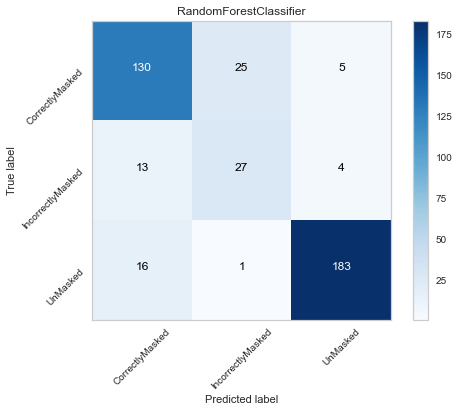

Confusion matrix, without normalization
[[124  19  17]
 [ 16  23   5]
 [ 24   2 174]]


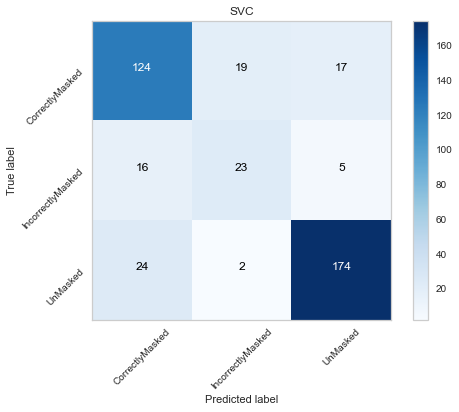

In [53]:
# looping through classifiers(ADAboost , RF , SVC ) and all the repos

    
#  make repos into a list 


all_repos = [
    
   ('Original Repo' ,originalrepo,target),
    ('Pre-processed Repo',PP_repoflatten,target),
    ('HOG Repo',HOG_pca,target),
    ('Augmented Repo',Augmented_repoflatten,Augmented_target),
    ('CD-SMOTE Repo', data_cdsmote,target_cdsmote) 
   ]

#split = [X_train,X_test, y_train, y_test,y_pred, y_predtrain]   - for reference from MyModels.py

X_train_idx = 0
X_test_idx = 1 
y_train_idx = 2 
y_test_idx = 3
y_pred_idx = 4 
y_predtrain_idx = 5

results_dict = []
split_list = []
models = []
train_scores = [] # new 
test_scores =[] # new 

for name,repo,targets in all_repos:
    print("\n Processing  ",name)
    
    models = [MyModels.ADAboost_mod(repo,targets,split_list),
              MyModels.RF(repo,targets,split_list),
              MyModels.SVClinear(repo,targets,split_list)]
     
    
    for i in range(len(split_list)):
        splits = split_list[i]
        model = models[i]    
        visualizer = ROCAUC(model)
        visualizer.fit(splits[X_train_idx],splits[y_train_idx])  # Fit the visualizer and the model (X_train y_train)
        visualizer.score(splits[X_test_idx],splits[y_test_idx])  # Evaluate the model on the test data (X_test y_test)
        visualizer.poof() 
        
    print(colored("\n Accuracy -Check for generalisation... -  for : %s\n"%(name),'green'))    # new section
    
    for i in range(len(split_list)): 
        
        model = models[i]
        splits = split_list[i] 
        modelname = model.__class__.__name__
        print(colored("\n %s\n"%(modelname),'green'))               
         # Append the accuracy score for the test and train predictions.
        train_scores.append(round(accuracy_score(splits[y_train_idx], splits[y_predtrain_idx]), 2))
        test_scores.append(round(accuracy_score(splits[y_test_idx], splits[y_pred_idx]), 2))
        # Print the train and test scores.
        print("The training scores were: {}".format(train_scores))
        print("The testing scores were: {}".format(test_scores))
        train_scores.clear()# new
        test_scores.clear()
    
    
    
    # print classification report 
    
    print(colored("\n The Classification Report for : %s\n"%(name),'green'))
    for i in range(len(split_list)):
        model = models[i]
        splits = split_list[i] 
        modelname = model.__class__.__name__
        y_test_c = []
        y_pred_c = [] 
        if(name == 'CD-SMOTE Repo'): #Join all subclasses for CD SMOTE
            for i,label in enumerate(splits[y_test_idx]):
                y_test_c.append(label.split('_')[0])
                y_pred_c.append(splits[y_pred_idx][i].split('_')[0])
        else :
            y_test_c = splits[y_test_idx]
            y_pred_c = splits[y_pred_idx]
        
        print(colored("\n %s\n"%(modelname),'green'))               
        print(classification_report(y_test_c, y_pred_c, zero_division=1))
        

    # plot Confusion Matrix 

    if(name == 'CD-SMOTE Repo'): #Join all subclasses for CD SMOTE
         classes = ['CorrectlyMasked','IncorrectlyMasked','UnMasked']
         for  cls,i in zip(models, range(len(split_list))):
           splits = split_list[i]
           y_test_c = []
           y_pred_c = []  
           for i,label in enumerate(splits[y_test_idx]):
                y_test_c.append(label.split('_')[0])
                y_pred_c.append(splits[y_pred_idx][i].split('_')[0])
           confusion_matrix = metrics.confusion_matrix(y_test_c, y_pred=y_pred_c) 
           plot_confusion_matrix_custom(confusion_matrix,classes,title =type(cls).__name__,normalize=False)
    else:
        ncols=len(split_list)    
        fig, axes = plt.subplots(nrows=1, ncols=len(split_list), figsize=(30,10))
        for  cls, ax,i in zip(models, axes,range(len(split_list))):
            splits = split_list[i]
            plot_confusion_matrix(cls, 
                            splits[X_test_idx], 
                            splits[y_test_idx], 
                            ax=ax, 
                            cmap='Blues',
                            xticks_rotation='vertical')
            ax.grid(False)
            ax.set_title(type(cls).__name__, fontdict={'fontsize': 15, 'fontweight': 'bold'})
            ax.set_yticklabels(ax.get_yticklabels(), rotation = 45, fontsize = 15)
            ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 15)
            
        plt.tight_layout() 
        plt.show()   
      
    models.clear()
    split_list.clear()
    results_dict.clear()



**Hyperparameter Tuning**

As the model were showing signs of overfitting(the test was  worser than train scores), the hyper parameters needs tuning. A faster way to tune is to use 'random searching',as discussed in [Random Search for Hyper-Parameter Optimization][7]. In this, a list of possible values is given and the values are randomly selected from it.A cross validation of 5 is used with random searching to determine the best model.
Tuning was repeated with valid hyperparameters for each model till all the model outputs were generalising well.All code used for classifiers and hyperparameter tuning can be found in MyModels.py, attached to the coursework submission.   
    
 [7]: https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf "Random_Search_for_Hyper-Parameter_Optimization"    

In [ ]:
**CNN for all repos**

Early stopping and callback was done for all repos and the best models have been used.Figure below shows the results for the original repo.

![1_CNNresults.png](attachment:1_CNNresults.png)




Processing for CNN  :  
 Original Repo
Shape of train before one-hot encoding:  (1520,)
Shape of train after one-hot encoding:  (1520, 3)

 Sample encoded value: 


The CNN Model is been initialised.. 


The CNN Model Summary 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 196, 196, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 98, 98, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 98, 98, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 307328)            0         
________________________

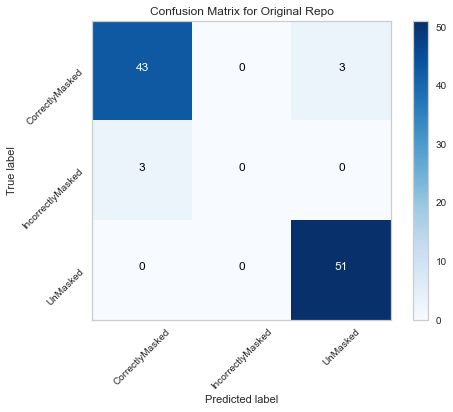

Confusion matrix, without normalization
[[ 0  0 46]
 [ 0  0  3]
 [ 0  0 51]]


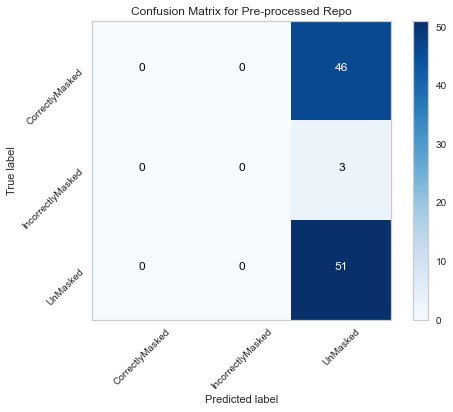

Confusion matrix, without normalization
[[45  1  0]
 [ 2  2  0]
 [ 0  0 50]]


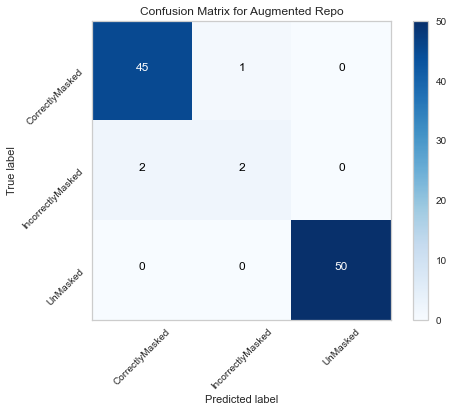

Confusion matrix, without normalization
[[ 2  0 40]
 [ 1  0 14]
 [ 0  0 43]]


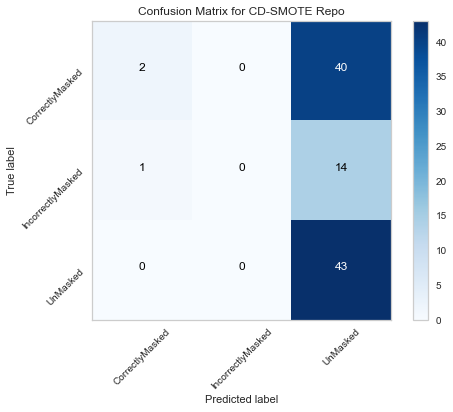

In [54]:

# looping through all repos with CNN
classes = ['CorrectlyMasked','IncorrectlyMasked','UnMasked']
all_repos1 = [
    
    ('Original Repo' ,originalrepo,target,'best_model_orig.h5'),
    ('Pre-processed Repo',PP_repoflatten,target,'best_model_pp.h5'),
    ('Augmented Repo',Augmented_repoflatten,Augmented_target,'best_model_aug.h5'),
    ('CD-SMOTE Repo', data_cdsmote,target_cdsmote,'best_model_cd.h5') 
   ]

split_list = [] 
for name,repo,targets,saved_model_name in all_repos1:
    
    print("\n\nProcessing for CNN  :  \n",name)
    if (name =='CD-SMOTE Repo'):
        labels=9 
    else:
        labels=3
    MyModels.CNN_mod(name, repo,targets,labels,saved_model_name,split_list)

 
# Print classification Reports for each Repo
for i in range(len(split_list)): 
    y_test_c = split_list[i][0]
    y_pred_c = split_list[i][1]
    print(colored("Classification Report for Repo:{}".format(all_repos1[i][0]),'green'))
    print(classification_report(y_test_c, y_pred=y_pred_c,zero_division=1))   

#Plot Confusion maatrix for each Repo
for i in range(len(split_list)): 
    y_test_c = split_list[i][0]
    y_pred_c = split_list[i][1]     
    confusion_matrix = metrics.confusion_matrix(y_test_c, y_pred=y_pred_c)  
    plot_confusion_matrix_custom(confusion_matrix,classes, title= "Confusion Matrix for {}".format(all_repos1[i][0])) 
  
    


In [ ]:
# # looping through all repos with CNN

# all_repos1 = [
    
#     ('Original Repo' ,originalrepo,target,'best_model_orig.h5'),
#     ('Pre-processed Repo',PP_repoflatten,target,'best_model_pp.h5'),
#     ('Augmented Repo',Augmented_repoflatten,Augmented_target,'best_model_aug.h5'),
#     ('CD-SMOTE Repo', data_cdsmote,target_cdsmote,'best_model_cd.h5') 
#    ]

 
# for name,repo,targets,saved_model_name in all_repos1:
    
#     print("\n\nProcessing for CNN  :  \n",name)
#     if (name =='CD-SMOTE Repo'):
#         labels=9 
#     else:
#         labels=3
#     MyModels.CNN_mod(name, repo,targets,labels,saved_model_name)
    
    
    

## <font color='blue'> Task 4: Final Reflection </font> 

## References: 




All references have been added as hyperlinks in the relevant sections.
